In [1]:
import numpy as np
import matplotlib.pyplot as plt
import apogee.select as apsel
import apogee.tools.read as apread
from galpy.util import bovy_plot, bovy_coords
from galpy.orbit import Orbit, Orbits
from galpy.potential import MWPotential2014
from galpy.util import multi
import mwdust
import gaia_tools
import tqdm
from gaia_tools import xmatch
from astropy.io import fits
import gaia_tools.load as gload
import dill as pickle
import multiprocessing
import os
import emcee
import scipy.optimize as op
params = {'axes.labelsize': 14, 'xtick.labelsize': 12, 'ytick.labelsize': 12, 'text.usetex': True, 'lines.linewidth': 1,
          'axes.titlesize': 14, 'font.family': 'serif'}
plt.rcParams.update(params)

columnwidth = 240./72.27
textwidth = 504.0/72.27

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload

/home/astjmack/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters



In [2]:
#load allStar
allstar = apread.allStar(main=True, rmdups=True,use_astroNN_distances=True)
len(allstar)

/home/astjmack/anaconda3/lib/python3.6/site-packages/apogee-1.-py3.6.egg/apogee/tools/read.py:1220: UserWarning: Adding distances from Leung & Bovy (2019b)
  warnings.warn("Adding distances from Leung & Bovy (2019b)")



100%|██████████| 43720/43720 [00:03<00:00, 11897.88it/s]


137748

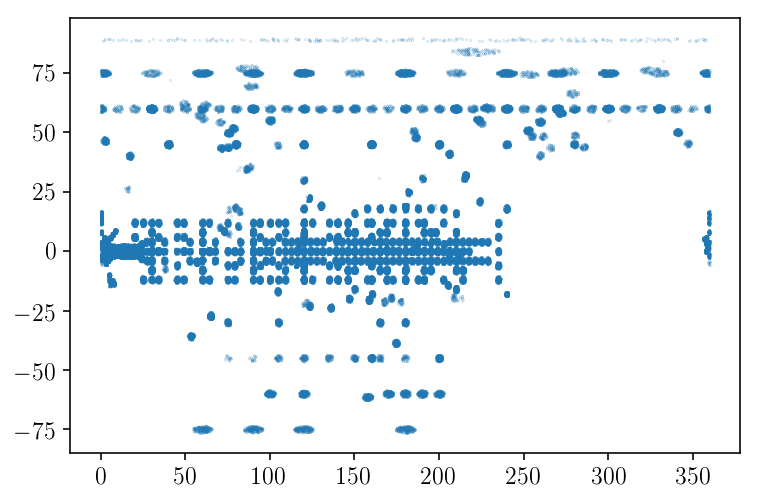

In [3]:
plt.scatter(allstar['GLON'], allstar['GLAT'], s=0.01)

In [4]:
#load selection function if it exists, if not, evaluate and pickle
force = False
if os.path.exists('../sav/apogeeCombinedSF.dat') and not force:
    with open('../sav/apogeeCombinedSF.dat', 'rb') as f:
        apo = pickle.load(f)
else:
    apo = apsel.apogeeCombinedSelect()
    del apo._specdata, apo._photdata
    with open('../sav/apogeeCombinedSF.dat', 'wb') as f:
        pickle.dump(apo, f)

In [5]:
#determine statistical sample and pickle file
force = False
if os.path.exists('../sav/statIndx.dat') and not force:
    with open('../sav/statIndx.dat', 'rb') as f:
        statIndx = pickle.load(f)
else:
    statIndx = apo.determine_statistical(allstar)
    with open('../sav/statIndx.dat', 'wb') as f:
        pickle.dump(statIndx, f)

(-0.2, 0.4)

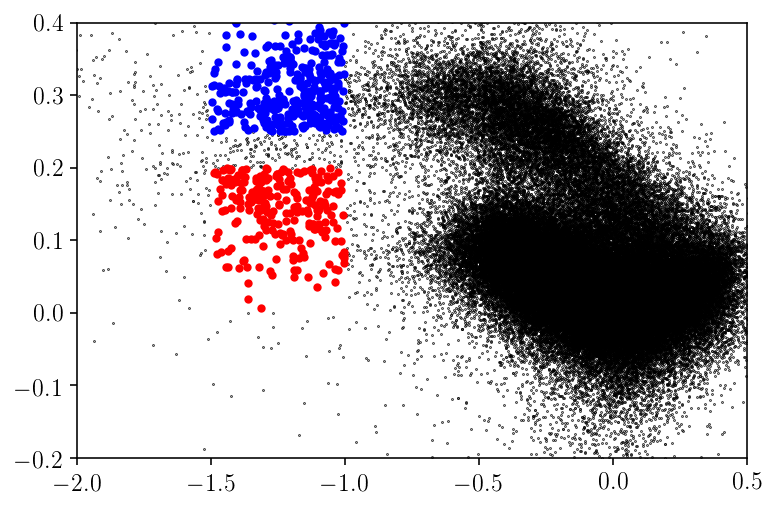

In [6]:

accreted = (allstar[statIndx]['FE_H'] > -1.5) & (allstar[statIndx]['FE_H'] < -1.) & (allstar[statIndx]['MG_FE'] < 0.2) & (allstar[statIndx]['MG_FE'] > 0.) 
control = (allstar[statIndx]['FE_H'] > -1.5) & (allstar[statIndx]['FE_H'] < -1.) & (allstar[statIndx]['MG_FE'] > 0.25) 
plt.scatter(allstar[statIndx]['FE_H'], allstar[statIndx]['MG_FE'], s=0.1, color='Black')
plt.scatter(allstar[statIndx][accreted]['FE_H'], allstar[statIndx][accreted]['MG_FE'], s=10, color='Red')
plt.scatter(allstar[statIndx][control]['FE_H'], allstar[statIndx][control]['MG_FE'], s=10, color='Blue')


plt.xlim(-2.,0.5)
plt.ylim(-0.2,0.4)

In [7]:
sum(accreted),sum(control)

(245, 365)

In [8]:
matched = allstar[statIndx][accreted]
cmatched = allstar[statIndx][control]

In [9]:
l, b, d = matched['GLON'], matched['GLAT'], matched['weighted_dist']/1e3
cl, cb, cd = cmatched['GLON'], cmatched['GLAT'], cmatched['weighted_dist']/1e3

In [10]:
XYZ = bovy_coords.lbd_to_XYZ(l,b,d, degree=True)
cXYZ = bovy_coords.lbd_to_XYZ(cl,cb,cd, degree=True)
Rphiz = bovy_coords.XYZ_to_galcencyl(XYZ[:,0], XYZ[:,1], XYZ[:,2], Xsun=8., Zsun=0.02)
cRphiz = bovy_coords.XYZ_to_galcencyl(cXYZ[:,0], cXYZ[:,1], cXYZ[:,2], Xsun=8., Zsun=0.02)

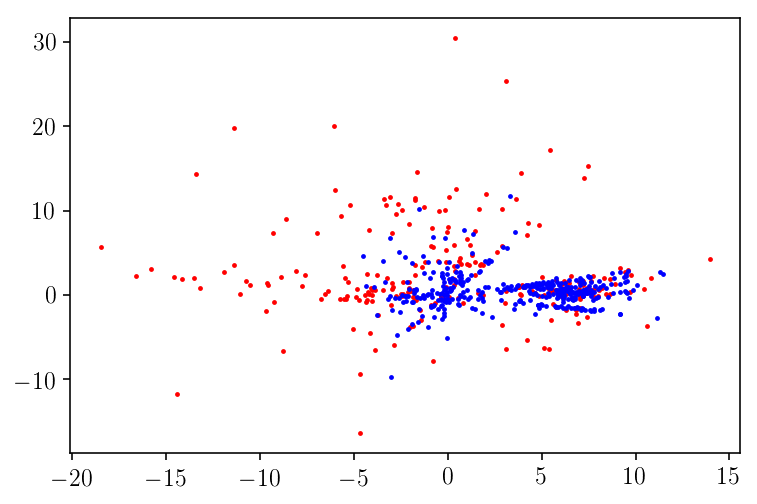

In [11]:
plt.scatter(XYZ[:,0], XYZ[:,2], c='Red', s=2.)
plt.scatter(cXYZ[:,0], cXYZ[:,2], c='Blue', s=2.)

In [12]:
dmap = mwdust.Combined15()
apof = apsel.apogeeEffectiveSelect(apo, dmap3d=dmap)

In [13]:
import isodist
from isodist import FEH2Z
zs = np.arange(0.0005,0.0605, 0.0005)
zlist = []
for i in range(len(zs)):
    zlist.append(format(zs[i],'.4f'))
iso = isodist.PadovaIsochrone(type='2mass-spitzer-wise', Z=zs, parsec=True)

logages = []
mets = []
js = []
hs = []
ks = []
loggs = []
teffs = []
imf = []
deltam = []
M_ini = []
M_act = []

iso_logages = iso._logages
iso_Zs = iso._ZS
for i in tqdm.tqdm(range(len(iso_logages))):
    for j in range(len(iso_Zs)):
        thisage = iso_logages[i]
        thisZ = iso_Zs[j]
        thisiso = iso(thisage, Z=thisZ)
        so = np.argsort(thisiso['M_ini'])
        loggs.extend(thisiso['logg'][so][1:])
        logages.extend(thisiso['logage'][so][1:])
        mets.extend(np.ones(len(thisiso['H'][so])-1)*thisZ)
        js.extend(thisiso['J'][so][1:])
        hs.extend(thisiso['H'][so][1:])
        ks.extend(thisiso['Ks'][so][1:])
        teffs.extend(thisiso['logTe'][so][1:])
        imf.extend(thisiso['int_IMF'][so][1:])
        deltam.extend(thisiso['int_IMF'][so][1:]-thisiso['int_IMF'][so][:-1])
        #thisimf = (thisiso['int_IMF'][so][1:]+thisiso['int_IMF'][so][:-1])/2.
        #deltam.extend(thisimf-np.cumsum(thisimf))
        M_ini.extend(thisiso['M_ini'][so][1:])
        M_act.extend(thisiso['M_act'][so][1:])
logages = np.array(logages)
mets = np.array(mets)
js = np.array(js)
hs = np.array(hs)
ks = np.array(ks)
loggs = np.array(loggs)
teffs = 10**np.array(teffs)
imf = np.array(imf)
deltam = np.array(deltam)
M_ini = np.array(M_ini)
M_act = np.array(M_act)

rec = np.recarray(len(deltam), dtype=[('logageyr', float),
                                      ('Z', float),
                                      ('J', float),
                                      ('H', float),
                                      ('K', float),
                                      ('logg', float),
                                      ('teff', float),
                                      ('int_IMF', float),
                                      ('deltaM', float),
                                      ('M_ini', float),
                                      ('M_act', float)])

rec['logageyr'] = logages
rec['Z'] = mets
rec['J'] = js
rec['H'] = hs
rec['K'] = ks
rec['logg'] = loggs
rec['teff'] = teffs
rec['int_IMF'] = imf
rec['deltaM'] = deltam
rec['M_ini'] = M_ini
rec['M_act'] = M_act



100%|██████████| 71/71 [00:03<00:00, 23.24it/s]


In [14]:
from scipy.interpolate import interp1d
from isodist import Z2FEH

def sampleiso(N, iso, return_inds=False, return_iso=False):
    weights = iso['deltaM']*(10**(iso['logageyr']-9)/iso['Z'])
    sort = np.argsort(weights)
    tinter = interp1d(np.cumsum(weights[sort])/np.sum(weights), range(len(weights[sort])), kind='linear')
    randinds = np.round(tinter(np.random.rand(N))).astype(np.int64)
    if return_inds:
        return randinds, iso['J'][sort][randinds], iso['H'][sort][randinds], iso['K'][sort][randinds]
    elif return_iso:
        return iso[sort][randinds]
    else:
        return iso['J'][sort][randinds], iso['H'][sort][randinds], iso['K'][sort][randinds]
    
def average_mass(iso):
    weights = iso['deltaM']*(10**(iso['logageyr']-9)/iso['Z'])
    return np.sum(iso['M_ini']*weights)/np.sum(weights)

def mass_ratio(iso):
    weights = iso['deltaM']*(10**(iso['logageyr']-9)/iso['Z'])
    mask = (iso['J']-iso['K'] > 0.3) & (iso['logg'] < 3.0)
    return np.sum(iso['M_ini'][mask]*weights[mask])/np.sum(iso['M_ini']*weights)

trec = np.copy(rec)

mask = (trec['J']-trec['K'] > 0.5)  & (Z2FEH(trec['Z']) < -1.) & (Z2FEH(trec['Z']) > -1.5) & (trec['M_ini'] > 0.75)
print(sum(mask))
niso = sampleiso(2000,trec[mask], return_iso=True)

mask = (trec['J']-trec['K'] > 0.3001)  & (Z2FEH(trec['Z']) < -1.) & (Z2FEH(trec['Z']) > -1.5) & (trec['M_ini'] > 0.75)

p3niso = sampleiso(2000,trec[mask], return_iso=True)

7188


0.5 201.0 0.0 0.0
4106


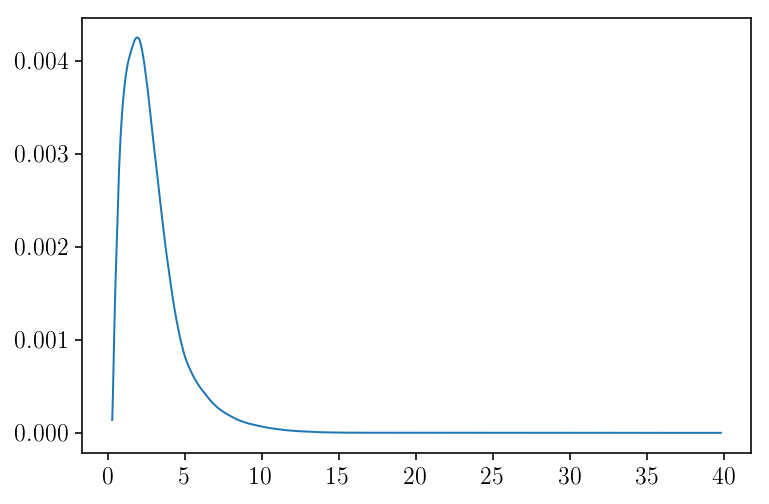

In [15]:
#test effsel...
i =3
#J, H, K = trec[mask][inds]['J'], trec[mask][inds]['H'], trec[mask][inds]['K']
J, H, K = niso['J'], niso['H'], niso['K']
p3J, p3H, p3K = p3niso['J'], p3niso['H'], p3niso['K']
distmods = np.linspace(7.,18.,401)
ds= 10.**(distmods/5-2.)
print(apo.JKmin(apo._locations[i]), np.nansum(apo._nspec_short[i]), np.nansum(apo._nspec_medium[i]), np.nansum(apo._nspec_long[i]))
print(apo._locations[i])

if apo.JKmin(apo._locations[i]) >= 0.5:
    effsel = apof(apo._locations[i], ds, MH=H, JK0=(J-K))
if apo.JKmin(apo._locations[i]) < 0.5:
    effsel = apof(apo._locations[i], ds, MH=p3H, JK0=(p3J-p3K))
plt.plot(ds,effsel)

In [16]:
def _calc_effsel_onelocation(i): 
    loc = apo._locations[i]
    if np.sum([np.nansum(apo._nspec_short[i]),np.nansum(apo._nspec_medium[i]),np.nansum(apo._nspec_long[i])]) < 1.:
        effsel = np.zeros(len(ds))
    elif apo.JKmin(loc) >= 0.5:
        effsel = apof(loc, ds, MH=H, JK0=(J-K))
    elif apo.JKmin(loc) < 0.5:
        effsel = apof(loc, ds, MH=p3H, JK0=(p3J-p3K))
 
    return effsel

distmods = np.linspace(7.,18.,301)
ds= 10.**(distmods/5-2.)
#out= multi.parallel_map((lambda x: _calc_effsel_onelocation(\
#                apo._locations[x],apof,apo,ds)),
#                            range(len(apo._locations)),
#                            numcores=np.amin([len(apo._locations),
#                                                 32/4.]))


In [18]:
with multiprocessing.Pool(int(multiprocessing.cpu_count()//8)) as p:
    output = list(tqdm.tqdm_notebook(p.imap(_calc_effsel_onelocation, range(0,len(apo._locations))), total=len(apo._locations)))
output = np.array(output)

HBox(children=(IntProgress(value=0, max=667), HTML(value='')))

/home/astjmack/anaconda3/lib/python3.6/site-packages/apogee-1.-py3.6.egg/apogee/select/apogeeSelect.py:2530: UserWarning: Different designs for this field have different radii; returning the first of these...
  warnings.warn("Different designs for this field have different radii; returning the first of these...")




In [17]:

#load effective selection function if it exists, if not, evaluate and pickle
force = False
if os.path.exists('../sav/apogeeCombinedSF.dat') and not force:
    with open('../essf/effsel_grid_NOAREA.dat', 'rb') as f:
        output = pickle.load(f)
    with open('../essf/effsel_grid_inclArea.dat', 'rb') as f:
        outarea = pickle.load(f)    
else:
    with multiprocessing.Pool(int(multiprocessing.cpu_count()//8)) as p:
        output = list(tqdm.tqdm_notebook(p.imap(_calc_effsel_onelocation, range(0,len(apo._locations))), total=len(apo._locations)))
        output = np.array(output)
    with open('../essf/effsel_grid_NOAREA.dat', 'wb') as f:
        pickle.dump(output, f)
    outarea = np.zeros_like(output)
    for i in range(len(output)):
        outarea[i] = output[i]*apo.area(apo._locations[i])
    with open('../essf/effsel_grid_inclArea.dat', 'wb') as f:
        pickle.dump(outarea, f)

In [20]:
outarea = np.zeros_like(output)
for i in range(len(output)):
    outarea[i] = output[i]*apo.area(apo._locations[i])

/home/astjmack/anaconda3/lib/python3.6/site-packages/apogee-1.-py3.6.egg/apogee/select/apogeeSelect.py:2530: UserWarning: Different designs for this field have different radii; returning the first of these...
  warnings.warn("Different designs for this field have different radii; returning the first of these...")



In [21]:
with open('../essf/effsel_grid_NOAREA.dat', 'wb') as f:
    pickle.dump(output, f)
with open('../essf/effsel_grid_inclArea.dat', 'wb') as f:
    pickle.dump(outarea, f)

In [21]:
goodfields = ~np.all(outarea < 1e-5, axis=1)

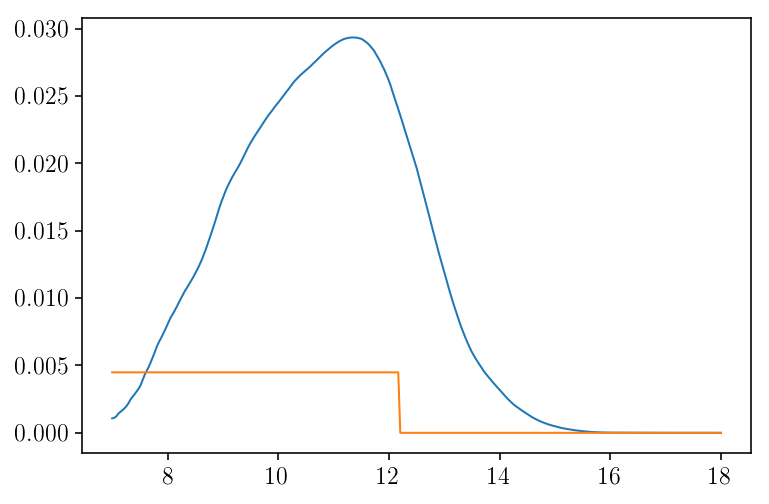

In [43]:
i = 3
plt.plot(distmods, outarea[i])
plt.plot(distmods, apo(apo._locations[i], distmods, JK0=np.ones(len(distmods))*0.6))

In [100]:
(3-1)/(4*np.pi)

0.15915494309189535

In [232]:
from galpy.util import _rotate_to_arbitrary_vector

#utilities for transformations etc

def rot(pa,zvec):
    if not isinstance(zvec,np.ndarray):
        zvec= np.array(zvec)
    pa_rot= np.array([[np.cos(pa),np.sin(pa),0.],
                         [-np.sin(pa),np.cos(pa),0.],
                         [0.,0.,1.]])
    zvec/= np.sqrt(np.sum(zvec**2.))
    zvec_rot= _rotate_to_arbitrary_vector(np.array([[0.,0.,1.]]),zvec,inv=True)[0]
    rot= np.dot(pa_rot,zvec_rot)
    return rot

def transform(vector):
    a = vector
    b = np.matrix([0,0,1])
    v = np.cross(a,b)
    s = np.linalg.norm(v)
    c = np.dot(a,b.T)
    vx = np.matrix([[0,-v[0,2],v[0,1]],[v[0,2],0,-v[0,0]],[-v[0,1],v[0,0],0]])
    transform = np.eye(3,3) + vx + (vx*vx)*(1/(1+c[0,0]))
    return transform

def transform_aby(xyz,alpha,beta,gamma):
    Rx = np.zeros([3,3])
    Ry = np.zeros([3,3])
    Rz = np.zeros([3,3])
    Rx[0,0] = 1
    Rx[1] = [0, np.cos(alpha), -np.sin(alpha)]
    Rx[2] = [0, np.sin(alpha), np.cos(alpha)]
    Ry[0] = [np.cos(beta), 0, np.sin(beta)]
    Ry[1,1] = 1
    Ry[2] = [-np.sin(beta), 0, np.cos(beta)]
    Rz[0] = [np.cos(gamma), -np.sin(gamma), 0]
    Rz[1] = [np.sin(gamma), np.cos(gamma), 0]
    Rz[2,2] = 1
    if np.ndim(xyz) == 1:
        tgalcenrect = np.dot(Rx, xyz)
        tgalcenrect = np.dot(Ry, tgalcenrect)
        tgalcenrect = np.dot(Rz, tgalcenrect)
        x, y, z = tgalcenrect[0], tgalcenrect[1], tgalcenrect[2]
    else:
        tgalcenrect = np.einsum('ij,aj->ai', Rx, xyz)
        tgalcenrect = np.einsum('ij,aj->ai', Ry, tgalcenrect)
        tgalcenrect = np.einsum('ij,aj->ai', Rz, tgalcenrect)
        x, y, z = tgalcenrect[:,0], tgalcenrect[:,1], tgalcenrect[:,2]
    return x, y, z

def lonlat_to_uvec(lon,lat):
    x = np.cos(lon)*np.sin(lat)
    y = np.sin(lon)*np.sin(lat)
    z = np.cos(lon)
    return x,y,z

def rot_pathetaphi(pa,theta,phi):
    lon, lat = theta,phi
    zvec = lonlat_to_uvec(lon, lat)
    return rot(pa,zvec)
    

#density models

def exponential_spherical(R,phi,z, params=[1/4.,]):
    r = np.sqrt(R**2+z**2)
    r0 = np.sqrt(8.**2+0.02**2)
    dens = np.exp(r*params[0])/np.exp(r0*params[0])
    return dens

def powerlaw_spherical(R,phi,z, params=[2.,]):
    r = np.sqrt(R**2+z**2)
    r0 = np.sqrt(8.**2+0.02**2)
    dens = r0**params[0]/r**params[0]
    return dens

def flattened_powerlaw(R,phi,z, params=[2.,0.6]):
    r = np.sqrt(R**2+z**2/params[1]**2)
    r0 = np.sqrt(8.**2+0.02**2/params[1]**2)
    dens =(1/r)**params[0]/(1/r0)**params[0]
    return dens

#def triaxial_powerlaw(R,phi,z,params=[2.,1.,1.,0.,0.,0.]):
#    rotpa = params[3]*np.pi
#    rottheta = params[4]*2*np.pi
#    rotphi = np.arccos(1-2*params[5])
#    grid = False
#    if np.ndim(R) > 1:
#        grid = True
#        dim = np.shape(R)
#        R = R.reshape(np.product(dim))
#        phi = phi.reshape(np.product(dim))
#        z = z.reshape(np.product(dim))
#    x, y, z = R*np.cos(phi), R*np.sin(phi), z
#    xyz = np.dstack([x,y,z])[0]
#    rot = rot_pathetaphi(rotpa,rottheta,rotphi)
#    if np.ndim(txyz) == 1:
#        tgalcenrect = np.dot(rot, xyz)
#        x, y, z = tgalcenrect[0], tgalcenrect[1], tgalcenrect[2]
#    else:
#        tgalcenrect = np.einsum('ij,aj->ai', rot, xyz)
#        x, y, z = tgalcenrect[:,0], tgalcenrect[:,1], tgalcenrect[:,2]
#    r = np.sqrt(x**2+y**2/params[1]**2+z**2/params[2]**2)
#    r0 = np.sqrt(8.**2+0.**2/params[1]**2+0.02**2/params[2]**2)
#    dens = (1/r)**(1/params[0])/((1/r0)**(1/params[0]))
#    if grid:
#        dens = dens.reshape(dim)
#    return dens

def triaxial_powerlaw(R,phi,z,params=[2.5,1.,1.,0.,0.,0.,0.001]):
    rotpa = params[3]*np.pi
    rottheta = params[4]*2*np.pi
    rotphi = np.arccos(1-2*params[5])
    grid = False
    if np.ndim(R) > 1:
        grid = True
        dim = np.shape(R)
        R = R.reshape(np.product(dim))
        phi = phi.reshape(np.product(dim))
        z = z.reshape(np.product(dim))
    x, y, z = R*np.cos(phi), R*np.sin(phi), z
    xyz = np.dstack([x,y,z])[0]
    rot = rot_pathetaphi(rotpa,rottheta,rotphi)
    if np.ndim(xyz) == 1:
        tgalcenrect = np.dot(rot, xyz)
        x, y, z = tgalcenrect[0], tgalcenrect[1], tgalcenrect[2]
    else:
        tgalcenrect = np.einsum('ij,aj->ai', rot, xyz)
        x, y, z = tgalcenrect[:,0], tgalcenrect[:,1], tgalcenrect[:,2]
    r = np.sqrt(x**2+y**2/params[1]**2+z**2/params[2]**2)
    r0 = np.sqrt(8.**2+0.**2/params[1]**2+0.02**2/params[2]**2)
    dens = (1/r)**(params[0])
    dens0 = (1/r0)**(params[0])
    dens = dens/dens0
    outdens = (1/np.sqrt(x**2+y**2+z**2))**1.5/(1/np.sqrt(8.**2+0.**2+0.02**2))**1.5
    dens = (1-params[6])*dens+params[6]*outdens
    if grid:
        dens = dens.reshape(dim)
    return dens

def helmi(R,phi,z,params=[2.5,1.,1.,0.,0.,0.]):
    alpha = params[3]*np.pi/2.
    beta = params[4]*np.pi/2.
    gamma = params[5]*np.pi/2.
    grid = False
    if np.ndim(R) > 1:
        grid = True
        dim = np.shape(R)
        R = R.reshape(np.product(dim))
        phi = phi.reshape(np.product(dim))
        z = z.reshape(np.product(dim))
    x, y, z = R*np.cos(phi), R*np.sin(phi), z
    xyz = np.dstack([x,y,z])[0]
    x, y, z = transform_aby(xyz, alpha,beta,gamma)
    dens = (x**2+y**2/params[1]**2+z**2/params[2]**2)**params[0]
    dens = dens/np.sqrt(8**2+0.02**2)**params[0]
    if grid:
        dens = dens.reshape(dim)
    return dens

def helmi_spherical(R,phi,z,params=[2.5,]):
    grid = False
    if np.ndim(R) > 1:
        grid = True
        dim = np.shape(R)
        R = R.reshape(np.product(dim))
        phi = phi.reshape(np.product(dim))
        z = z.reshape(np.product(dim))
    x, y, z = R*np.cos(phi), R*np.sin(phi), z
    dens = (x**2+y**2+z**2)**params[0]
    dens = dens/np.sqrt(8**2+0.02**2)**params[0]
    if grid:
        dens = dens.reshape(dim)
    return dens

def helmi_axisymmetric(R,phi,z,params=[2.5,1.]):
    grid = False
    if np.ndim(R) > 1:
        grid = True
        dim = np.shape(R)
        R = R.reshape(np.product(dim))
        phi = phi.reshape(np.product(dim))
        z = z.reshape(np.product(dim))
    x, y, z = R*np.cos(phi), R*np.sin(phi), z
    dens = (x**2+y**2+z**2/params[1]**2)**params[0]
    dens = dens/np.sqrt(8**2+0.02**2)**params[0]
    if grid:
        dens = dens.reshape(dim)
    return dens

def helmi_norot(R,phi,z,params=[2.5,1.,1.]):
    grid = False
    if np.ndim(R) > 1:
        grid = True
        dim = np.shape(R)
        R = R.reshape(np.product(dim))
        phi = phi.reshape(np.product(dim))
        z = z.reshape(np.product(dim))
    x, y, z = R*np.cos(phi), R*np.sin(phi), z
    dens = (x**2+y**2/params[1]**2+z**2/params[2]**2)**params[0]
    dens = dens/np.sqrt(8**2+0.02**2)**params[0]
    if grid:
        dens = dens.reshape(dim)
    return dens
    
def hernquist_spherical(R,phi,z,params=[1/4.,]):
    a = 1/params[0]
    grid = False
    if np.ndim(R) > 1:
        grid = True
        dim = np.shape(R)
        R = R.reshape(np.product(dim))
        phi = phi.reshape(np.product(dim))
        z = z.reshape(np.product(dim))
    txyz = bovy_coords.galcencyl_to_XYZ(R, phi, z, Xsun=8., Zsun=0.02)
    if np.ndim(txyz) == 1:
        galcenrect = bovy_coords.XYZ_to_galcenrect(txyz[0], txyz[1], txyz[2], Xsun=8., Zsun=0.02)
        x, y, z = galcenrect[0], galcenrect[1], galcenrect[2]
    else:
        galcenrect = bovy_coords.XYZ_to_galcenrect(txyz[:,0], txyz[:,1], txyz[:,2], Xsun=8., Zsun=0.02)
        x, y, z = galcenrect[:,0], galcenrect[:,1], galcenrect[:,2]
    x0, y0, z0 = 8., 0., 0.02
    m = np.sqrt(x**2+(y**2/1**2)+(z**2/1**2))
    m0 = np.sqrt(x0**2+(y0**2/1**2)+(z0**2/1**2))
    dens = 1/(4*np.pi*a**3)*1/((m/a)*(1+m/a)**3)
    dens0 = 1/(4*np.pi*a**3)*1/((m0/a)*(1+m0/a)**3)
    if grid:
        dens = dens.reshape(dim)
    return dens/dens0

def hernquist(R,phi,z,params=[4.,1.,1.,0.,0.,0.]):
    rotpa = params[3]*np.pi
    rottheta = params[4]*2*np.pi
    rotphi = np.arccos(1-2*params[5])
    grid = False
    if np.ndim(R) > 1:
        grid = True
        dim = np.shape(R)
        R = R.reshape(np.product(dim))
        phi = phi.reshape(np.product(dim))
        z = z.reshape(np.product(dim))
    x, y, z = R*np.cos(phi), R*np.sin(phi), z
    xyz = np.dstack([x,y,z])[0]
    rot = rot_pathetaphi(rotpa,rottheta,rotphi)
    if np.ndim(xyz) == 1:
        tgalcenrect = np.dot(rot, xyz)
        x, y, z = tgalcenrect[0], tgalcenrect[1], tgalcenrect[2]
    else:
        tgalcenrect = np.einsum('ij,aj->ai', rot, xyz)
        x, y, z = tgalcenrect[:,0], tgalcenrect[:,1], tgalcenrect[:,2]
    r = np.sqrt(x**2+y**2/params[1]**2+z**2/params[2]**2)
    r0 = np.sqrt(8.**2+0.**2/params[1]**2+0.02**2/params[2]**2)
    a = 1/params[0]
    dens = 1/(4*np.pi*a**3)*1/((r/a)*(1+r/a)**3)
    dens0 = 1/(4*np.pi*a**3)*1/((r0/a)*(1+r0/a)**3)
    if grid:
        dens = dens.reshape(dim)
    return dens/dens0

# Likelihood calculation

def Rphizgrid(apo,distmods):
    ds = 10**(distmods/5.-2.)
    Rgrid = np.zeros((len(apo._locations),len(ds)))
    phigrid = np.zeros((len(apo._locations),len(ds)))
    zgrid = np.zeros((len(apo._locations),len(ds)))
    for i in range(len(apo._locations)):
        glon,glat = apo.glonGlat(apo._locations[i])
        glon = np.ones(len(ds))*glon[0]
        glat = np.ones(len(ds))*glat[0]
        xyz = bovy_coords.lbd_to_XYZ(glon,glat,ds)
        rphiz = bovy_coords.XYZ_to_galcencyl(xyz[:,0], xyz[:,1], xyz[:,2], Xsun=8., Zsun=0.02)
        Rgrid[i] = rphiz[:,0]
        phigrid[i] = rphiz[:,1]
        zgrid[i] = rphiz[:,2]
    return Rgrid, phigrid, zgrid



def tdens(densfunc, Rgrid, phigrid, zgrid, params=None):
    if params is None:
        dens = densfunc(Rgrid,phigrid,zgrid)
    else:
        dens = densfunc(Rgrid,phigrid,zgrid,params=params)
    return dens

def effvol(densfunc, effsel, Rgrid, phigrid, zgrid, params=None):
    if params is None:
        effdens = tdens(densfunc,Rgrid,phigrid,zgrid)
    else:
        effdens = tdens(densfunc,Rgrid,phigrid,zgrid,params=params)
    return np.sum(effdens*effsel)
    
def loglike(params, densfunc, effsel, Rgrid, phigrid, zgrid, dataR, dataphi, dataz):
    if not check_prior(densfunc, params):
        return -np.inf
    logdatadens = np.log(tdens(densfunc, dataR, dataphi, dataz, params=params))
    logeffvol = np.log(effvol(densfunc,effsel,Rgrid,phigrid,zgrid,params=params))
    return np.sum(logdatadens)-len(dataR)*logeffvol

def check_prior(densfunc, params):
    if densfunc is exponential_spherical:
        return True
    if densfunc is powerlaw_spherical:
        return True
    if densfunc is flattened_powerlaw:
        if params[1] < 0.: return False
        elif params[1] > 3.: return False
        elif params[0] < 0.: return False
        else: return True
    if densfunc is triaxial_powerlaw:
        if params[1] < 0.:return False
        elif params[1] > 1.:return False
        elif params[2] < 0.:return False
        elif params[2] > 1.:return False
        elif params[3] < 0.: return False
        elif params[3] > 1.: return False
        elif params[4] < 0.: return False
        elif params[4] > 1.:return False
        elif params[5] < 0.:return False
        elif params[5] > 1.:return False
        elif params[6] < 0.:return False
        elif params[6] > 1.:return False
        else: return True
    if densfunc is helmi:
        if params[0] > 0.:return False
        elif params[1] < 0.:return False
        elif params[1] > 1.:return False
        elif params[2] < 0.:return False
        elif params[2] > 1.:return False
        elif params[3] < 0.: return False
        elif params[3] > 1.: return False
        elif params[4] < 0.: return False
        elif params[4] > 1.:return False
        elif params[5] < 0.:return False
        elif params[5] > 1.:return False
        else: return True
    if densfunc is helmi_spherical:
        if params[0] > 0.:return False
        else: return True
    if densfunc is helmi_axisymmetric:
        if params[0] > 0.:return False
        elif params[1] < 0.:return False
        elif params[1] > 1.:return False
        else: return True
    if densfunc is helmi_norot:
        if params[0] > 0.:return False
        elif params[1] < 0.:return False
        elif params[1] > 1.:return False
        elif params[2] < 0.:return False
        elif params[2] > 1.:return False
        else: return True
    if densfunc is hernquist:
        if params[0] < 0.: return False
        elif params[1] > 1.: return False
        elif params[1] < 0.: return False
        elif params[2] > 1.: return False
        elif params[2] < 0.: return False
        elif params[3] > 2.: return False
        elif params[3] < 0.: return False
        elif params[4] > 1/2.: return False
        elif params[4] < -1/2.: return False
        elif params[5] > 2.: return False
        elif params[5] < 0.: return False
        else: return True
    if densfunc is hernquist_spherical:
        if params[0] < 0.: return False
        else: return True
        

def mloglike(*args, **kwargs):
    return -loglike(*args,**kwargs)

In [45]:
Rgrid, phigrid, zgrid =  Rphizgrid(apo,distmods)

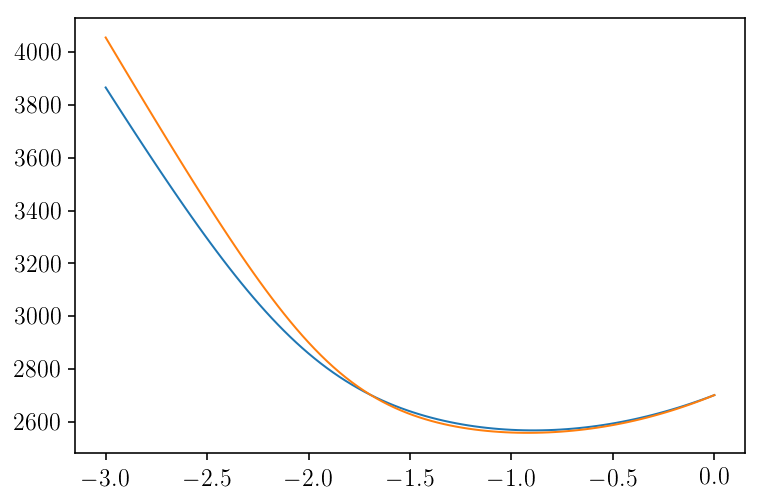

In [233]:
alphas = np.linspace(-3.,0.,100)
loglikes = np.zeros(len(alphas))
tloglikes = np.zeros(len(alphas))
for i in range(len(alphas)):
    loglikes[i] = mloglike([alphas[i],1.],helmi_axisymmetric, outarea[goodfields]*ds**2.*(distmods[1]-distmods[0]), Rgrid[goodfields], phigrid[goodfields], zgrid[goodfields], Rphiz[:,0], Rphiz[:,1], Rphiz[:,2])
    tloglikes[i] = mloglike([alphas[i],0.6],helmi_axisymmetric, outarea[goodfields]*ds**2.*(distmods[1]-distmods[0]), Rgrid[goodfields], phigrid[goodfields], zgrid[goodfields], Rphiz[:,0], Rphiz[:,1], Rphiz[:,2])
plt.plot(alphas, loglikes)
plt.plot(alphas,tloglikes)

In [48]:
triaxial_powerlaw(Rgrid,phigrid,zgrid)

array([[1.00389739, 1.00394251, 1.00398766, ..., 0.01938174, 0.01860452,
        0.01785763],
       [0.99095949, 0.99078583, 0.99060855, ..., 0.01785924, 0.01716458,
        0.01649591],
       [1.06689338, 1.06807802, 1.06928443, ..., 0.03072608, 0.02923592,
        0.02782169],
       ...,
       [1.01136163, 1.01153533, 1.01171131, ..., 0.02035184, 0.01952033,
        0.01872212],
       [1.00038221, 1.00036737, 1.00035155, ..., 0.01894914, 0.01819571,
        0.01747133],
       [0.97184764, 0.97136036, 0.97086454, ..., 0.01591967, 0.01532543,
        0.0147522 ]])

In [50]:
rz = np.mgrid[0:10.:100j,-5:5:100j]
ph = np.zeros_like(rz[0])

denst = hernquist(rz[0],ph,rz[1], params=[-0.08599058,  0.66997512,  0.87010853,  0.83048983,  0.27938911,  1.6608238 ])
denst = hernquist(rz[0],ph,rz[1], params=[1/9.,  0.2,  0.2,  0.,  0.,  0. ])
denstd = hernquist(rz[0],ph,rz[1], params=[1/3.,  1., 1.,  0.,  0., 0. ])

In [179]:
xyzgrid = np.mgrid[-10.:10.:100j,-10.:10.:100j,-10.:10.:100j]
print(np.shape(xyzgrid))
shape = np.shape(xyzgrid.T)
xyzgrid = xyzgrid.T.reshape(np.product(shape[:3]),shape[3])
rphizgrid = bovy_coords.rect_to_cyl(xyzgrid[:,0], xyzgrid[:,1], xyzgrid[:,2])
rphizgrid = np.dstack([rphizgrid[0],rphizgrid[1],rphizgrid[2]])[0]
rphizgrid = rphizgrid.reshape(100,100,100,3).T
print(np.shape(rphizgrid))
denstxyz = helmi(rphizgrid[0],rphizgrid[1],rphizgrid[2], params=[-0.9,0.5,0.5,0.,0.,0.])
print(np.shape(denstxyz))

(3, 100, 100, 100)
(3, 100, 100, 100)
(100, 100, 100)


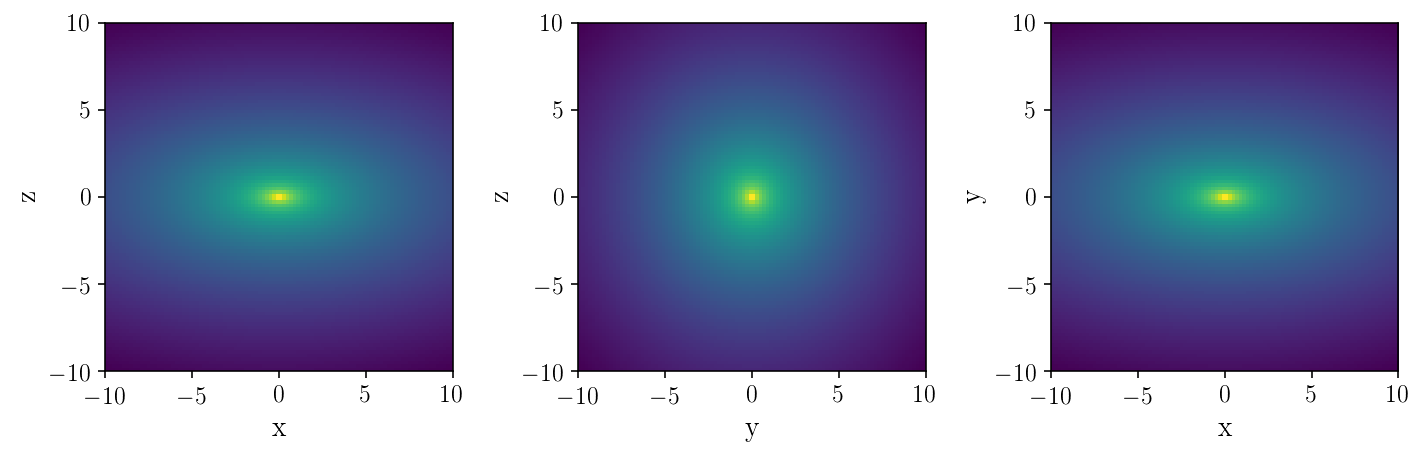

In [180]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(10,10)
ax[1].imshow(np.rot90(np.log10(np.sum(denstxyz, axis=0))), extent=[-10,10,-10,10])
ax[0].imshow(np.rot90(np.log10(np.sum(denstxyz, axis=1))), extent=[-10,10,-10,10])
ax[2].imshow(np.rot90(np.log10(np.sum(denstxyz, axis=2))), extent=[-10,10,-10,10])

ax[2].set_xlabel(r'x')
ax[2].set_ylabel(r'y')
ax[0].set_xlabel(r'x')
ax[0].set_ylabel(r'z')
ax[1].set_xlabel(r'y')
ax[1].set_ylabel(r'z')
fig.tight_layout()

In [167]:
transform_aby([1.,0.,0.], 0.,np.pi/2.,0.)

(6.123233995736766e-17, 0.0, -1.0)

In [27]:
plt.plot(rz[0][:,0],np.log10(np.rot90(denst)[50]))
plt.plot(rz[0][:,0],np.log10(np.rot90(denstd)[50]))



NameError: name 'rz' is not defined

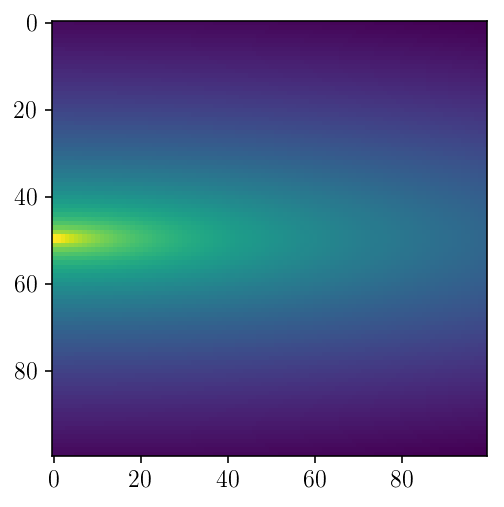

In [354]:
plt.imshow(np.rot90(np.log10(denst)))

In [189]:


np.linalg.norm(lonlat_to_uvec(np.pi/5.,np.pi/5.))

1.0

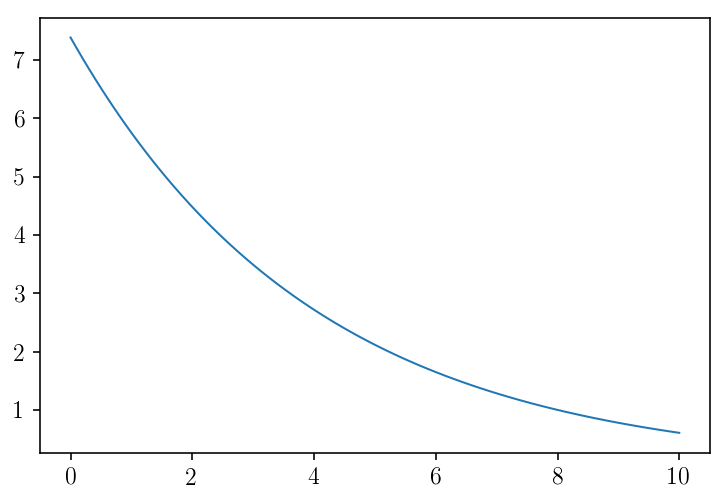

In [46]:
r = np.linspace(0.,10.,100)
plt.plot(r, exponential(r,np.zeros(100), np.zeros(100)))

82

In [1462]:
effvol(powerlaw_spherical,outarea, Rgrid, phigrid, zgrid, params=[0.1])

62025.38130230098

In [1463]:
mloglike([100.,0.3,0.2,0.,0.,0.],triaxial_powerlaw, outarea*ds**2.*(distmods[1]-distmods[0])*(ds*np.log(10)/5.), Rgrid, phigrid, zgrid, Rphiz[:,0], Rphiz[:,1], Rphiz[:,2])

1912.052749583958

In [198]:

exp_par = op.fmin(lambda x: mloglike(x,exponential_spherical, outarea[goodfields]*ds**2.*(distmods[1]-distmods[0]), Rgrid[goodfields], phigrid[goodfields], zgrid[goodfields], Rphiz[:,0], Rphiz[:,1], Rphiz[:,2]), [10.,])
powerlaw_par = op.fmin(lambda x: mloglike(x,powerlaw_spherical, outarea[goodfields]*ds**2.*(distmods[1]-distmods[0]), Rgrid[goodfields], phigrid[goodfields], zgrid[goodfields], Rphiz[:,0], Rphiz[:,1], Rphiz[:,2]), [2.,])
hernquist_spher_par = op.fmin(lambda x: mloglike(x,hernquist_spherical, outarea[goodfields]*ds**2.*(distmods[1]-distmods[0]), Rgrid[goodfields], phigrid[goodfields], zgrid[goodfields], Rphiz[:,0], Rphiz[:,1], Rphiz[:,2]), [1/5.,])
fpowerlaw_par = op.fmin(lambda x: mloglike(x,flattened_powerlaw, outarea[goodfields]*ds**2.*(distmods[1]-distmods[0]), Rgrid[goodfields], phigrid[goodfields], zgrid[goodfields], Rphiz[:,0], Rphiz[:,1], Rphiz[:,2]), [1/5.,0.6])
triaxial_par = op.fmin(lambda x: mloglike(x,triaxial_powerlaw, outarea[goodfields]*ds**2.*(distmods[1]-distmods[0]), Rgrid[goodfields], phigrid[goodfields], zgrid[goodfields], Rphiz[:,0], Rphiz[:,1], Rphiz[:,2]), [2.5,0.6,0.6,0.,0.,0.,0.1])
hernquist_par = op.fmin(lambda x: mloglike(x,hernquist, outarea[goodfields]*ds**2.*(distmods[1]-distmods[0]), Rgrid[goodfields], phigrid[goodfields], zgrid[goodfields], Rphiz[:,0], Rphiz[:,1], Rphiz[:,2]), [1/5.,0.6,0.6,0.,0.,0.])
helmi_par = op.fmin(lambda x: mloglike(x,helmi, outarea[goodfields]*ds**2.*(distmods[1]-distmods[0]), Rgrid[goodfields], phigrid[goodfields], zgrid[goodfields], Rphiz[:,0], Rphiz[:,1], Rphiz[:,2]), [-2.,0.6,0.6,0.,0.,0.])
helmin_par = op.fmin(lambda x: mloglike(x,helmi_norot, outarea[goodfields]*ds**2.*(distmods[1]-distmods[0]), Rgrid[goodfields], phigrid[goodfields], zgrid[goodfields], Rphiz[:,0], Rphiz[:,1], Rphiz[:,2]), [-2.,0.6,0.6])
helmis_par = op.fmin(lambda x: mloglike(x,helmi_spherical, outarea[goodfields]*ds**2.*(distmods[1]-distmods[0]), Rgrid[goodfields], phigrid[goodfields], zgrid[goodfields], Rphiz[:,0], Rphiz[:,1], Rphiz[:,2]), [-2.,])

Optimization terminated successfully.
         Current function value: 2630.803178
         Iterations: 22
         Function evaluations: 44
Optimization terminated successfully.
         Current function value: 2568.368022
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 2588.640031
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 2557.150025
         Iterations: 58
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: 2507.381037
         Iterations: 618
         Function evaluations: 1022
Optimization terminated successfully.
         Current function value: 2571.212128
         Iterations: 474
         Function evaluations: 782
Optimization terminated successfully.
         Current function value: 2547.675565
         Iterations: 92
         Function evaluations: 165
Optimi

In [264]:
models = [helmi_spherical, helmi_axisymmetric, helmi_norot, helmi]
inits = [[-2.,], [-2.,0.99], [-2.,0.99,0.99], [-2.,0.99,0.99,0.,0.,0.]] 
opts, fopts = [], []
for i,model in enumerate(models):
    opt = op.fmin(lambda x: mloglike(x,model, outarea[goodfields]*ds**2.*(distmods[1]-distmods[0]), Rgrid[goodfields], phigrid[goodfields], zgrid[goodfields], Rphiz[:,0], Rphiz[:,1], Rphiz[:,2]), inits[i], full_output=True)
    opts.append(opt[0])
    fopts.append(opt[1])
    
print(opts)

Optimization terminated successfully.
         Current function value: 2568.368022
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 2557.150025
         Iterations: 48
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: 2547.675566
         Iterations: 117
         Function evaluations: 217
Optimization terminated successfully.
         Current function value: 2546.875557
         Iterations: 584
         Function evaluations: 931
[array([-0.89179687]), array([-0.89149164,  0.42053446]), array([-0.92239471,  0.40158124,  0.56377436]), array([-9.20387518e-01,  3.98877821e-01,  5.38346868e-01,  2.26876308e-09,
        7.07346244e-03,  2.37894937e-03])]


In [308]:
opts,np.array(fopts)*-1

([array([-0.89179687]),
  array([-0.89149164,  0.42053446]),
  array([-0.92239471,  0.40158124,  0.56377436]),
  array([-9.20387518e-01,  3.98877821e-01,  5.38346868e-01,  2.26876308e-09,
          7.07346244e-03,  2.37894937e-03])],
 array([-2568.36802187, -2557.15002482, -2547.67556574, -2546.87555734]))

In [309]:
def implied_mass(densfunc,params):
    isomask = (Z2FEH(trec['Z']) < -1.) & (Z2FEH(trec['Z']) > -1.5) & (trec['J']-trec['K'] > 0.3)
    avmass = average_mass(trec[isomask])
    isomask = (Z2FEH(trec['Z']) < -1.) & (Z2FEH(trec['Z']) > -1.5) & (trec['J']-trec['K'] > 0.3)
    massratio = mass_ratio(trec[isomask])
    xyzgrid = np.mgrid[-100.:100.:150j,-100.:100.:150j,-100.:100.:150j]
    delta = xyzgrid[0,:,0,0][1]-xyzgrid[0,:,0,0][0]
    shape = np.shape(xyzgrid.T)
    xyzgrid = xyzgrid.T.reshape(np.product(shape[:3]),shape[3])
    rphizgrid = bovy_coords.rect_to_cyl(xyzgrid[:,0], xyzgrid[:,1], xyzgrid[:,2])
    rphizgrid = np.dstack([rphizgrid[0],rphizgrid[1],rphizgrid[2]])[0]
    rphizgrid = rphizgrid.reshape(150,150,150,3).T
    rate = densfunc(Rgrid[goodfields],phigrid[goodfields],zgrid[goodfields],params=params)/densfunc(8.,0.,0.02, params=params)*outarea[goodfields]*ds**2.*(distmods[1]-distmods[0])
    sumrate = np.sum(rate)
    norm = len(Rphiz)/sumrate
    fac = norm*(180/np.pi)**2*avmass/massratio
    denstxyz = densfunc(rphizgrid[0],rphizgrid[1],rphizgrid[2], params=params)/densfunc(8.,0.,0.02, params=params)*fac
    return np.sum(denstxyz)*(delta*delta*delta)

def pdistmod_model(densfunc, params):
    rate = (densfunc(Rgrid[goodfields],phigrid[goodfields],zgrid[goodfields],params=params)/densfunc(8.,0.,0.02, params=params)*outarea[goodfields]*ds**2.)*(distmods[1]-distmods[0])
    hout = np.zeros((len(rate), len(distmods)))
    for ii in range(len(rate)):
        tjac = np.ones_like(distmods)
        tXs = distmods[rate[ii] > 0.]
        sindx =np.argsort(tXs)
        tXs = tXs[sindx]
        trate = rate[ii,rate[ii] > 0.][sindx]
        tjac= tjac[rate[ii] > 0.][sindx]
        ipthis= np.log(trate*tjac+10.**-8.)
        baseline= np.polynomial.Polynomial.fit(tXs,ipthis,4)
        ipthis= ipthis/baseline(tXs)
        sp= interpolate.InterpolatedUnivariateSpline(tXs,ipthis,k=3)
        tindx= (distmods >= np.amin(tXs))\
            *(distmods <= np.amax(tXs))
        hout[ii,tindx]= (np.exp(sp(distmods[tindx])*baseline(distmods[tindx]))-10.**-8.)
    hout[np.isinf(tout)] =0.
    pdt = hout.sum(axis=0)
    pd = pdt/np.sum(pdt)/(distmods[1]-distmods[0])
    return pd, pdt



In [310]:
for i in range(len(opts)):
    print(np.log10(implied_mass(models[i],opts[i])))

8.018921957961112
7.978860962591515
7.854681375392316
7.855260279917


/home/astjmack/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "



Text(0.5,0,'$\\mu$')

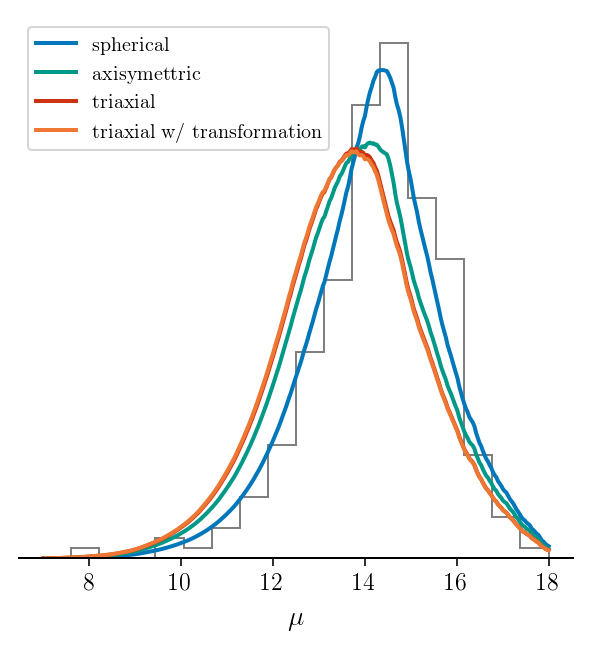

In [311]:
data_d = d
data_distmod = 5*np.log10(data_d*1e3)-5
model_names = ['spherical', 'axisymettric', 'triaxial', 'triaxial w/ transformation']
colours = ['#0077BB', '#009988', '#CC3311', '#EE7733']
fig = plt.figure()
fig.set_size_inches(1.5*columnwidth,1.5*columnwidth)
for i in range(len(models)):
    pd, pdt = pdistmod_model(models[i], opts[i])
    plt.plot(distmods,pd, lw=2., color=colours[i], label=model_names[i])
plt.hist(data_distmod, normed=True, range=[distmods[0],distmods[-1]], bins=18, color='gray', histtype='step')
ax = plt.gca()
plt.legend(loc=2)
ax.axes.get_yaxis().set_visible(False)
ax.set_frame_on(False)
xmin, xmax = ax.get_xaxis().get_view_interval()
ymin, ymax = ax.get_yaxis().get_view_interval()
ax.add_artist(plt.Line2D((xmin, xmax), (ymin, ymin), color='black', linewidth=2))
ax.set_xlabel(r'$\mu$')

In [313]:
helmi_spherical(8.,0.,0.02)

181.02075019842343

In [28]:
powerlaw_par = op.fmin(lambda x: mloglike(x,powerlaw_spherical, outarea[goodfields]*ds**2.*(distmods[1]-distmods[0])*(ds*np.log(10)/5.), Rgrid[goodfields], phigrid[goodfields], zgrid[goodfields], Rphiz[:,0], Rphiz[:,1], Rphiz[:,2]), [1/25.,])
cpowerlaw_par = op.fmin(lambda x: mloglike(x,powerlaw_spherical, outarea[goodfields]*ds**2.*(distmods[1]-distmods[0])*(ds*np.log(10)/5.), Rgrid[goodfields], phigrid[goodfields], zgrid[goodfields], cRphiz[:,0], cRphiz[:,1], cRphiz[:,2]), [1/25.,])
print(powerlaw_par, cpowerlaw_par)

Optimization terminated successfully.
         Current function value: 3024.249765
         Iterations: 23
         Function evaluations: 46
Optimization terminated successfully.
         Current function value: 4431.832988
         Iterations: 24
         Function evaluations: 48
[1.6734375] [1.9026875]


In [29]:
exp_par = op.fmin(lambda x: mloglike(x,exponential_spherical, outarea[goodfields]*ds**2.*(distmods[1]-distmods[0])*(ds*np.log(10)/5.), Rgrid[goodfields], phigrid[goodfields], zgrid[goodfields], Rphiz[:,0], Rphiz[:,1], Rphiz[:,2]), [1/25.,])
cexp_par = op.fmin(lambda x: mloglike(x,exponential_spherical, outarea[goodfields]*ds**2.*(distmods[1]-distmods[0])*(ds*np.log(10)/5.), Rgrid[goodfields], phigrid[goodfields], zgrid[goodfields], cRphiz[:,0], cRphiz[:,1], cRphiz[:,2]), [1/25.,])
print(1/exp_par, 1/cexp_par)

Optimization terminated successfully.
         Current function value: 2989.886720
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 4326.632862
         Iterations: 18
         Function evaluations: 36
[-6.20876989] [-4.522329]


In [42]:
triaxial_par = op.fmin(lambda x: mloglike(x,triaxial_powerlaw, outarea[goodfields]*ds**2.*(distmods[1]-distmods[0]), Rgrid[goodfields], phigrid[goodfields], zgrid[goodfields], Rphiz[:,0], Rphiz[:,1], Rphiz[:,2]),[2.5,0.6,0.6,0.,0.,0.,0.1])
ctriaxial_par = op.fmin(lambda x: mloglike(x,triaxial_powerlaw, outarea[goodfields]*ds**2.*(distmods[1]-distmods[0]), Rgrid[goodfields], phigrid[goodfields], zgrid[goodfields], cRphiz[:,0], cRphiz[:,1], cRphiz[:,2]),[2.5,0.6,0.6,0.,0.,0.,0.1])
print(triaxial_par, ctriaxial_par)

Optimization terminated successfully.
         Current function value: 2507.381037
         Iterations: 618
         Function evaluations: 1022
[3.82743319e+00 3.70301764e-02 6.41785617e-01 5.61686493e-12
 1.85108421e-05 3.55929522e-11 6.76954401e-02] [2.96528257e+01 3.11117369e-02 4.91882489e-01 1.15801905e-04
 5.60499726e-03 3.48533666e-07 2.97998489e-01]


In [547]:
print(np.__version__)

1.15.4


In [71]:
print(powerlaw_par)
print(1/exp_par)
print(1/hernquist_par)
print(fpowerlaw_par)
print(triaxial_par)
print(hernquist_par)

[2.21689453]
[-5.4413816]
[5.07243286e+01 5.05558223e+00 6.31150954e+00 1.40280449e+02
 2.19324021e+02 4.57251799e+12]
[1.99592547 0.20794641]
[4.30571189e-05 8.02541363e+00 9.77013693e-02 3.28924247e-01
 7.66905175e-09 2.16554667e-03 9.38379115e-04 5.25598237e-02]
[1.97144058e-02 1.97801154e-01 1.58440702e-01 7.12857713e-03
 4.55946411e-03 2.18697882e-13]


/home/astjmack/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in true_divide



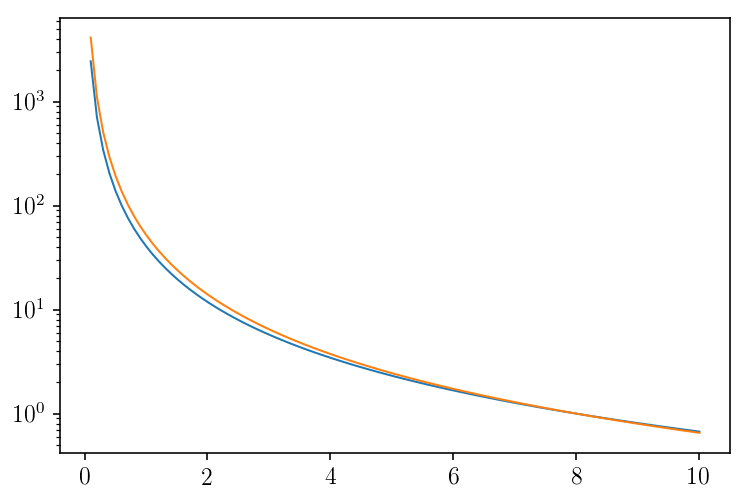

In [1533]:
r = np.linspace(0.,10.,100)
plt.plot(r, powerlaw_spherical(r,np.zeros(100),np.zeros(100),params=powerlaw_par))
plt.plot(r, powerlaw_spherical(r,np.zeros(100),np.zeros(100),params=cpowerlaw_par))
#plt.plot(r, exponential_spherical(r,np.zeros(100),np.zeros(100),params=exp_par))
#plt.plot(r, hernquist_spherical(r,np.zeros(100),np.zeros(100),params=hernquist_par))
plt.yscale('log')


In [72]:
ndim, nwalkers = 1, 200
pos = [powerlaw_par + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]

In [112]:
(3-3.02)/4/np.pi/100**(3.02)

-1.4515103323688165e-09

In [122]:
loglike([4.],powerlaw_spherical, effsel_in, Rgrid_in, phigrid_in, zgrid_in, Rphiz[:,0], Rphiz[:,1], Rphiz[:,2])

-1142.6377082645968

In [200]:
ndim, nwalkers = 1, 200
pos = [helmis_par + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]
nit = 500
threads = 8
effsel_in = outarea[goodfields]*ds**2.*(distmods[1]-distmods[0])
Rgrid_in, phigrid_in, zgrid_in = Rgrid[goodfields], phigrid[goodfields], zgrid[goodfields]

sampler = emcee.EnsembleSampler(nwalkers, ndim, loglike, 
                                    args=(helmi_spherical, effsel_in, Rgrid_in, phigrid_in, zgrid_in, Rphiz[:,0], Rphiz[:,1], Rphiz[:,2]), 
                                    threads=threads)
for i, result in tqdm.tqdm_notebook(enumerate(sampler.sample(pos, iterations=nit)), total=nit):
    continue

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

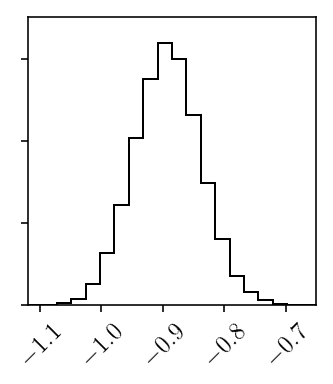

In [201]:
samples = sampler.chain[:, 40:, :].reshape((-1, ndim))

fig = corner.corner(samples)

In [65]:
ndim, nwalkers = 1, 100
pos = [powerlaw_par + 1*np.random.randn(ndim) for i in range(nwalkers)]
cpos = [cpowerlaw_par + 1*np.random.randn(ndim) for i in range(nwalkers)]

nit = 500
threads = 4
sampler = emcee.EnsembleSampler(nwalkers, ndim, loglike, 
                                    args=(powerlaw_spherical, outarea*ds**2.*(distmods[1]-distmods[0])*(ds*np.log(10)/5.), Rgrid, phigrid, zgrid, Rphiz[:,0], Rphiz[:,1], Rphiz[:,2]), 
                                    threads=threads)
for i, result in tqdm.tqdm_notebook(enumerate(sampler.sample(pos, iterations=nit)), total=nit):
    continue

nit = 500
threads = 4
csampler = emcee.EnsembleSampler(nwalkers, ndim, loglike, 
                                    args=(powerlaw_spherical, outarea*ds**2.*(distmods[1]-distmods[0])*(ds*np.log(10)/5.), Rgrid, phigrid, zgrid, cRphiz[:,0], cRphiz[:,1], cRphiz[:,2]), 
                                    threads=threads)
for i, result in tqdm.tqdm_notebook(enumerate(csampler.sample(cpos, iterations=nit)), total=nit):
    continue

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

In [183]:
ndim, nwalkers = 6, 200
pos = [helmi_par + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

nit = 500
threads = 8
sampler = emcee.EnsembleSampler(nwalkers, ndim, loglike, 
                                    args=(helmi, outarea[goodfields]*ds**2.*(distmods[1]-distmods[0]), Rgrid[goodfields], phigrid[goodfields], zgrid[goodfields], Rphiz[:,0], Rphiz[:,1], Rphiz[:,2]),
                                   threads = threads)
for i, result in tqdm.tqdm_notebook(enumerate(sampler.sample(pos, iterations=nit)), total=nit):
    continue

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

In [120]:
ndim, nwalkers = 3, 200
pos = [helmin_par + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

nit = 500
threads = 8
sampler = emcee.EnsembleSampler(nwalkers, ndim, loglike, 
                                    args=(helmi_norot, outarea[goodfields]*ds**2.*(distmods[1]-distmods[0]), Rgrid[goodfields], phigrid[goodfields], zgrid[goodfields], Rphiz[:,0], Rphiz[:,1], Rphiz[:,2]),
                                   threads = threads)
for i, result in tqdm.tqdm_notebook(enumerate(sampler.sample(pos, iterations=nit)), total=nit):
    continue

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

In [31]:
ndim, nwalkers = 7, 200
pos = [triaxial_par + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

nit = 500
threads = 8
sampler = emcee.EnsembleSampler(nwalkers, ndim, loglike, 
                                    args=(triaxial_powerlaw, outarea[goodfields]*ds**2.*(distmods[1]-distmods[0]), Rgrid[goodfields], phigrid[goodfields], zgrid[goodfields], Rphiz[:,0], Rphiz[:,1], Rphiz[:,2]),
                                   threads = threads)
for i, result in tqdm.tqdm_notebook(enumerate(sampler.sample(pos, iterations=nit)), total=nit):
    continue

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

In [184]:
samples = sampler.chain[:, 300:, :].reshape((-1, ndim))
#csamples = csampler.chain[:, 40:, :].reshape((-1, ndim))


In [185]:
import corner

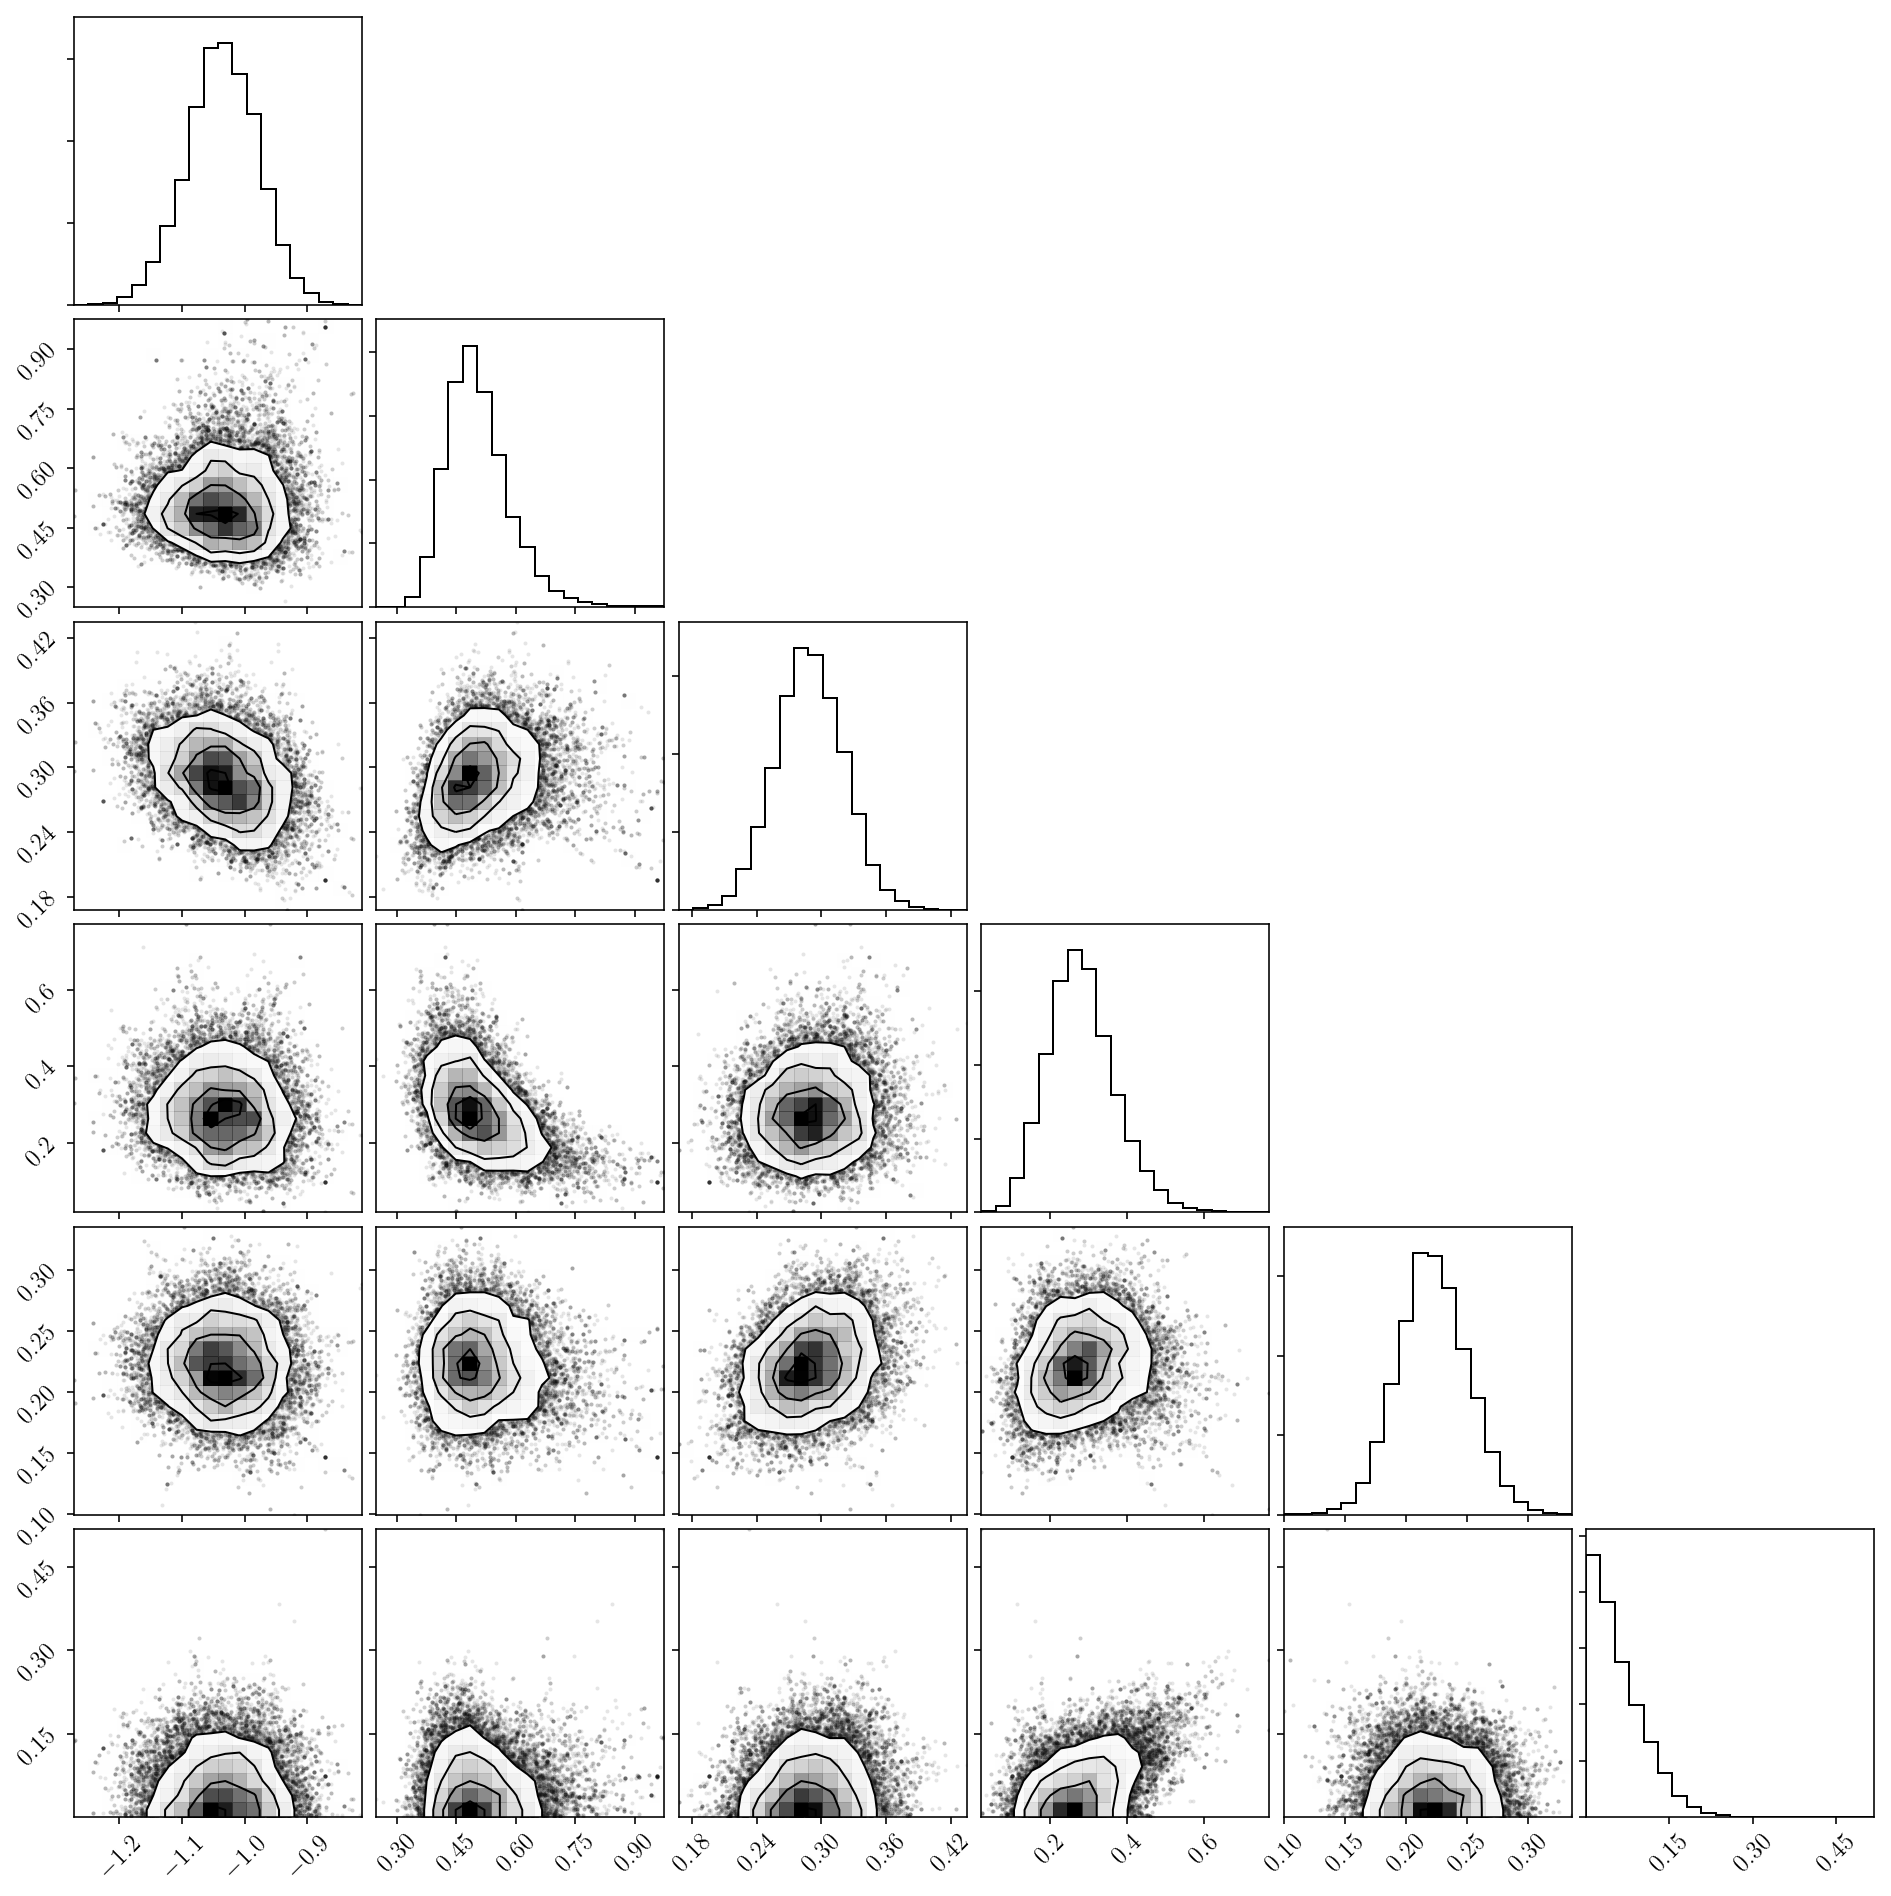

In [186]:
fig = corner.corner(samples)

In [130]:
transform_aby(np.pi/2.,0.,0.)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [35]:
triaxial_par

array([1.00428554e+01, 7.02936440e-02, 2.51535014e-01, 1.04478305e-03,
       5.21874556e-12, 1.12059495e-15, 3.89161086e-02])

In [1539]:
np.median(samples, axis=0)

array([5.04290060e-01, 6.44341092e-02, 1.29232828e-01, 1.74731783e-03,
       3.52221432e-02, 9.10123179e-05, 2.35189963e-03])

(array([   19.,   339.,  1742.,  6366., 12560., 13544.,  8301.,  2622.,
          462.,    45.]),
 array([0.12977382, 0.23367334, 0.33757286, 0.44147237, 0.54537189,
        0.64927141, 0.75317092, 0.85707044, 0.96096996, 1.06486948,
        1.16876899]),
 <a list of 1 Patch objects>)

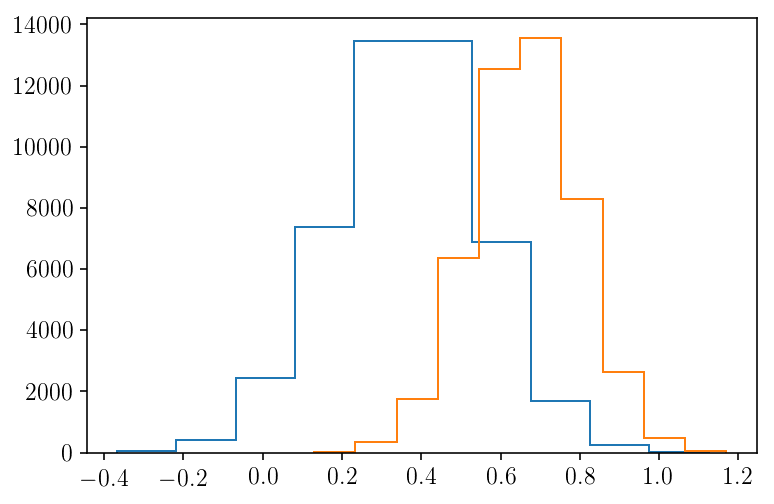

In [893]:
plt.hist(samples, histtype='step')
plt.hist(csamples, histtype='step')

/home/astjmack/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide



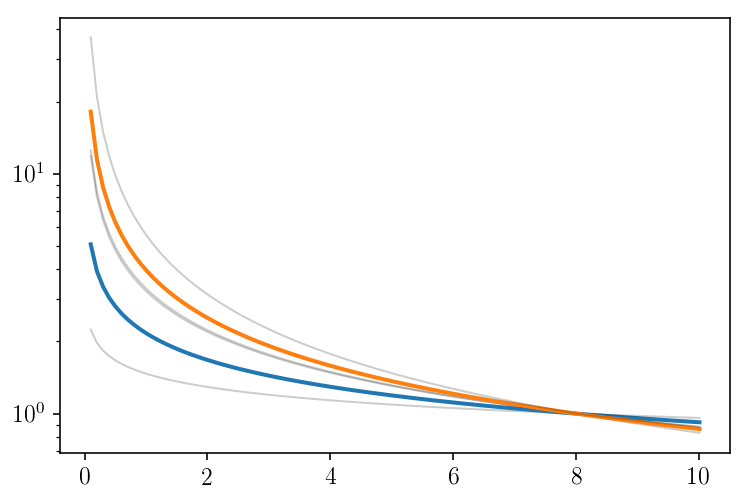

In [895]:
r = np.linspace(0.,10.,100)
densities = np.empty([400,100])
cdensities = np.empty([400,100])
for i in range(len(densities)):
    densities[i] = powerlaw_spherical(r,np.zeros(100),np.zeros(100),params=[samples[i]])
    cdensities[i] = powerlaw_spherical(r,np.zeros(100),np.zeros(100),params=[csamples[i]])
plt.plot(r, np.percentile(densities, 16, axis=0), alpha=0.2, color='Black')
plt.plot(r, powerlaw_spherical(r,np.zeros(100),np.zeros(100),params=[np.median(samples)]), lw=2.)
plt.plot(r, np.percentile(densities, 84, axis=0), alpha=0.2, color='Black')

plt.plot(r, np.percentile(cdensities, 16, axis=0), alpha=0.2, color='Black')
plt.plot(r, powerlaw_spherical(r,np.zeros(100),np.zeros(100),params=[np.median(csamples)]), lw=2.)
plt.plot(r, np.percentile(cdensities, 84, axis=0), alpha=0.2, color='Black')
plt.yscale('log')


In [215]:
rate = powerlaw_spherical(Rgrid[goodfields],phigrid[goodfields],zgrid[goodfields],params=[np.median(samples)])*outarea[goodfields]*ds**2.*(distmods[1]-distmods[0])*(ds*np.log(10)/5.)
sumrate = np.sum(rate)

norm = len(Rphiz)/sumrate

isomask = (Z2FEH(trec['Z']) < -1.) & (Z2FEH(trec['Z']) > -1.5) & (trec['J']-trec['K'] > 0.3)

avmass = average_mass(trec[isomask])

isomask = (Z2FEH(trec['Z']) < -1.) & (Z2FEH(trec['Z']) > -1.5) & (trec['J']-trec['K'] > 0.3)

massratio = mass_ratio(trec[isomask])

In [216]:
massratio

0.009464469721631903

In [217]:
avmass/massratio

32.032742535266685

In [218]:
fac = norm*(180/np.pi)**2*avmass/massratio #M_sun pc^-3 ???

In [219]:
from scipy.integrate import nquad

In [222]:
xyzgrid = np.mgrid[-100.:100.:150j,-100.:100.:150j,-100.:100.:150j]
delta = xyzgrid[0,:,0,0][1]-xyzgrid[0,:,0,0][0]
print(np.shape(xyzgrid))
shape = np.shape(xyzgrid.T)
xyzgrid = xyzgrid.T.reshape(np.product(shape[:3]),shape[3])
rphizgrid = bovy_coords.rect_to_cyl(xyzgrid[:,0], xyzgrid[:,1], xyzgrid[:,2])
rphizgrid = np.dstack([rphizgrid[0],rphizgrid[1],rphizgrid[2]])[0]
rphizgrid = rphizgrid.reshape(150,150,150,3).T
masses = np.zeros(400)
powers = samples
for ii,power in tqdm.tqdm_notebook(enumerate(powers[np.random.randint(len(powers), size=400)]), total=400):
    rate = helmi_spherical(Rgrid[goodfields],phigrid[goodfields],zgrid[goodfields],params=[power,])*outarea[goodfields]*ds**3.*(distmods[1]-distmods[0])
    sumrate = np.sum(rate)
    norm = len(Rphiz)/sumrate
    fac = norm*(180/np.pi)**2*avmass/massratio
    denstxyz = powerlaw_spherical(rphizgrid[0],rphizgrid[1],rphizgrid[2], params=[power,])*fac
    masses[ii] =  np.sum(denstxyz)*(delta*delta*delta)

print(np.shape(denstxyz))

(3, 150, 150, 150)


HBox(children=(IntProgress(value=0, max=400), HTML(value='')))


(150, 150, 150)


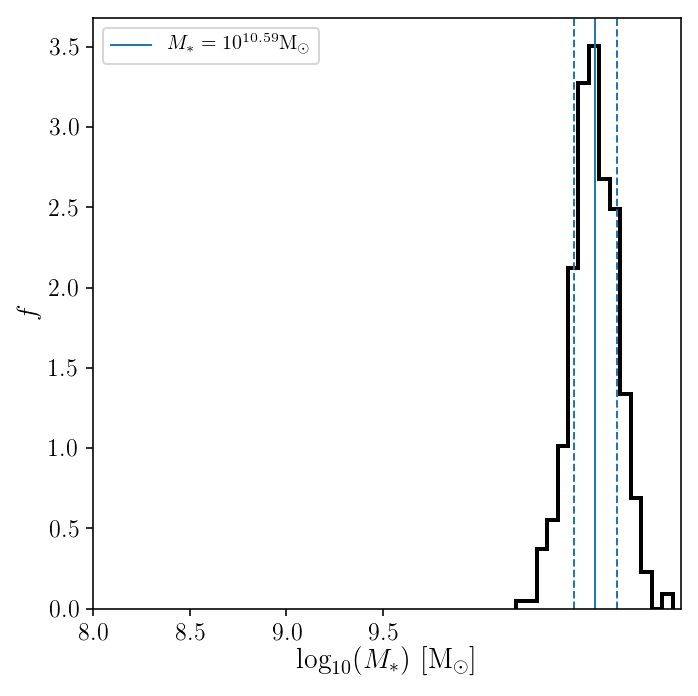

In [223]:
fig = plt.figure()
fig.set_size_inches(1.5*columnwidth,1.5*columnwidth)
plt.hist(np.log10(masses), histtype='step', lw=2., color='Black', density=True, bins=15)

plt.axvline(np.log10(np.median(masses)), label=r'$M_* = 10^{'+str(round(np.log10(np.median(masses)),2))+r'}\mathrm{M_{\odot}}$')
plt.axvline(np.log10(np.percentile(masses, 16)), linestyle='dashed')
plt.axvline(np.log10(np.percentile(masses, 84)), linestyle='dashed')
plt.xticks([8.,8.5,9.,9.5])
plt.xlabel(r'$\log_{10}(M_*)\ \mathrm{[M_{\odot}]}$')
plt.ylabel(r'$f$')
plt.legend()
fig.tight_layout()
#plt.savefig('../plots/powerlaw_spherical_mass_post.pdf', format='pdf')
#plt.savefig('../plots/powerlaw_spherical_mass_post.png', format='png', dpi=400)

/home/astjmack/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in true_divide



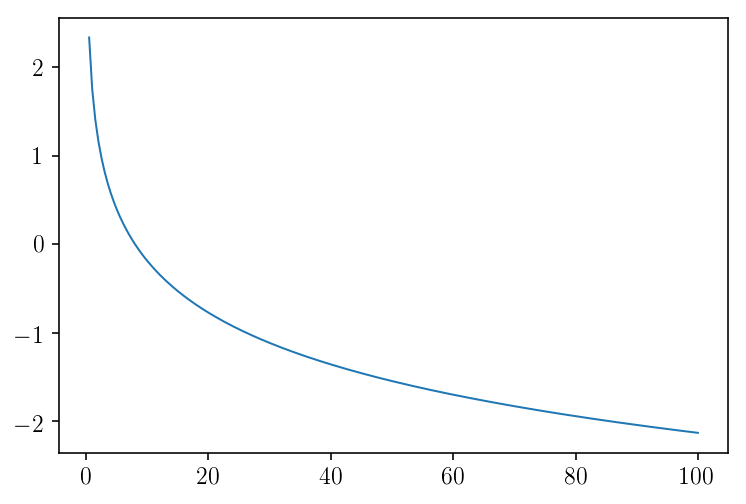

In [540]:
rs = np.linspace(0.,100., 200)

dens = powerlaw_spherical(rs,np.ones(len(rs)),np.zeros(len(rs)),params=[power,])

plt.plot(rs, np.log10(dens))

In [193]:
rate = helmi(Rgrid[goodfields],phigrid[goodfields],zgrid[goodfields],params=np.median(samples, axis=0))*outarea[goodfields]*ds**2.*(distmods[1]-distmods[0])
sumrate = np.sum(rate)

norm = len(Rphiz)/sumrate

isomask = (Z2FEH(trec['Z']) < -1.) & (Z2FEH(trec['Z']) > -1.5) & (trec['J']-trec['K'] > 0.3)

avmass = average_mass(trec[isomask])

isomask = (Z2FEH(trec['Z']) < -1.) & (Z2FEH(trec['Z']) > -1.5)

massratio = mass_ratio(trec[isomask])

In [76]:
np.log10(np.mean(masses))

NameError: name 'masses' is not defined

In [77]:
massratio

0.008060102440155424

In [78]:
avmass/massratio

37.61402836711537

In [1238]:
fac = norm*(180/np.pi)**2*avmass/massratio #M_sun kpc^-3 ???

In [1239]:
from scipy.integrate import nquad

In [194]:
xyzgrid = np.mgrid[-100.:100.:150j,-100.:100.:150j,-100.:100.:150j]
delta = xyzgrid[0,:,0,0][1]-xyzgrid[0,:,0,0][0]
print(np.shape(xyzgrid))
shape = np.shape(xyzgrid.T)
xyzgrid = xyzgrid.T.reshape(np.product(shape[:3]),shape[3])
rphizgrid = bovy_coords.rect_to_cyl(xyzgrid[:,0], xyzgrid[:,1], xyzgrid[:,2])
rphizgrid = np.dstack([rphizgrid[0],rphizgrid[1],rphizgrid[2]])[0]
rphizgrid = rphizgrid.reshape(150,150,150,3).T
masses = np.zeros(400)
for ii,power in tqdm.tqdm_notebook(enumerate(samples[np.random.randint(len(samples), size=400)]), total=400):
    rate = helmi(Rgrid[goodfields],phigrid[goodfields],zgrid[goodfields],params=power)*outarea[goodfields]*ds**2.*(distmods[1]-distmods[0])
    sumrate = np.sum(rate)
    norm = len(Rphiz)/sumrate
    fac = norm*(180/np.pi)**2*avmass/massratio
    denstxyz = helmi(rphizgrid[0],rphizgrid[1],rphizgrid[2], params=power)*fac
    masses[ii] =  np.sum(denstxyz)*(delta*delta*delta)

print(np.shape(denstxyz))

(3, 150, 150, 150)


HBox(children=(IntProgress(value=0, max=400), HTML(value='')))


(150, 150, 150)


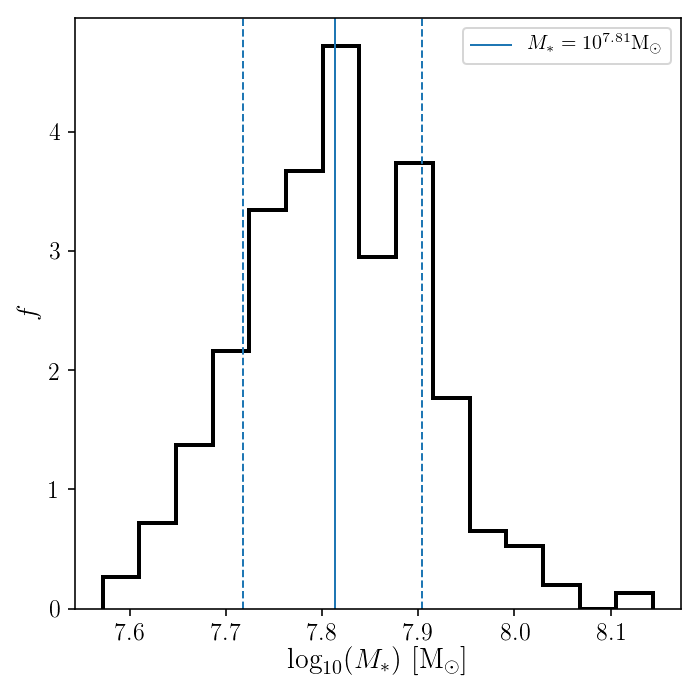

In [195]:
fig = plt.figure()
fig.set_size_inches(1.5*columnwidth,1.5*columnwidth)
plt.hist(np.log10(masses), histtype='step', lw=2., color='Black', density=True, bins=15)
plt.axvline(np.log10(np.median(masses)), label=r'$M_* = 10^{'+str(round(np.log10(np.median(masses)),2))+r'}\mathrm{M_{\odot}}$')
plt.axvline(np.log10(np.percentile(masses, 16)), linestyle='dashed')
plt.axvline(np.log10(np.percentile(masses, 84)), linestyle='dashed')
plt.xlabel(r'$\log_{10}(M_*)\ \mathrm{[M_{\odot}]}$')
plt.ylabel(r'$f$')
plt.legend()
fig.tight_layout()
#plt.savefig('../plots/powerlaw_spherical_mass_post.pdf', format='pdf')
#plt.savefig('../plots/powerlaw_spherical_mass_post.png', format='png', dpi=400)

In [207]:
from scipy import interpolate
rate = (helmi_spherical(Rgrid[goodfields],phigrid[goodfields],zgrid[goodfields],params=helmis_par)*outarea[goodfields]*ds**2.)*(distmods[1]-distmods[0])
out = np.zeros((len(rate), len(distmods)))
for ii in range(len(rate)):
    tjac = np.ones_like(distmods)
    tXs = distmods[rate[ii] > 0.]
    sindx =np.argsort(tXs)
    tXs = tXs[sindx]
    trate = rate[ii,rate[ii] > 0.][sindx]
    tjac= tjac[rate[ii] > 0.][sindx]
    ipthis= np.log(trate*tjac+10.**-8.)
    baseline= np.polynomial.Polynomial.fit(tXs,ipthis,4)
    ipthis= ipthis/baseline(tXs)
    sp= interpolate.InterpolatedUnivariateSpline(tXs,ipthis,k=3)
    tindx= (distmods >= np.amin(tXs))\
        *(distmods <= np.amax(tXs))
    out[ii,tindx]= (np.exp(sp(distmods[tindx])*baseline(distmods[tindx]))-10.**-8.)
out[np.isinf(out)] =0.

rate = (triaxial_powerlaw(Rgrid[goodfields],phigrid[goodfields],zgrid[goodfields],params=triaxial_par)*outarea[goodfields]*ds**2.)*(distmods[1]-distmods[0])
tout = np.zeros((len(rate), len(distmods)))
for ii in range(len(rate)):
    tjac = np.ones_like(distmods)
    tXs = distmods[rate[ii] > 0.]
    sindx =np.argsort(tXs)
    tXs = tXs[sindx]
    trate = rate[ii,rate[ii] > 0.][sindx]
    tjac= tjac[rate[ii] > 0.][sindx]
    ipthis= np.log(trate*tjac+10.**-8.)
    baseline= np.polynomial.Polynomial.fit(tXs,ipthis,4)
    ipthis= ipthis/baseline(tXs)
    sp= interpolate.InterpolatedUnivariateSpline(tXs,ipthis,k=3)
    tindx= (distmods >= np.amin(tXs))\
        *(distmods <= np.amax(tXs))
    tout[ii,tindx]= (np.exp(sp(distmods[tindx])*baseline(distmods[tindx]))-10.**-8.)
tout[np.isinf(tout)] =0.

rate = (helmi(Rgrid[goodfields],phigrid[goodfields],zgrid[goodfields],params=helmi_par)*outarea[goodfields]*ds**2.)*(distmods[1]-distmods[0])
hout = np.zeros((len(rate), len(distmods)))
for ii in range(len(rate)):
    tjac = np.ones_like(distmods)
    tXs = distmods[rate[ii] > 0.]
    sindx =np.argsort(tXs)
    tXs = tXs[sindx]
    trate = rate[ii,rate[ii] > 0.][sindx]
    tjac= tjac[rate[ii] > 0.][sindx]
    ipthis= np.log(trate*tjac+10.**-8.)
    baseline= np.polynomial.Polynomial.fit(tXs,ipthis,4)
    ipthis= ipthis/baseline(tXs)
    sp= interpolate.InterpolatedUnivariateSpline(tXs,ipthis,k=3)
    tindx= (distmods >= np.amin(tXs))\
        *(distmods <= np.amax(tXs))
    hout[ii,tindx]= (np.exp(sp(distmods[tindx])*baseline(distmods[tindx]))-10.**-8.)
hout[np.isinf(tout)] =0.

In [208]:
data_d = d
data_distmod = 5*np.log10(data_d*1e3)-5

/home/astjmack/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "



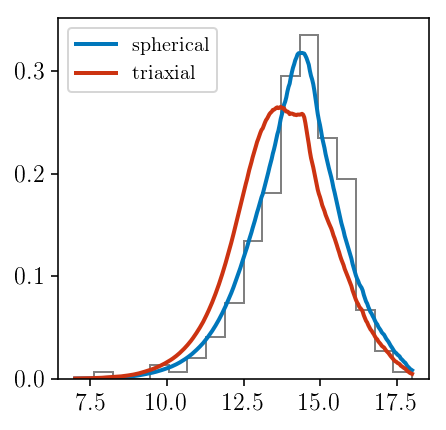

In [211]:
pdt = out.sum(axis=0)
pd = pdt/np.sum(pdt)/(distmods[1]-distmods[0])

tpdt = tout.sum(axis=0)
tpd = tpdt/np.sum(tpdt)/(distmods[1]-distmods[0])


hpdt = hout.sum(axis=0)
hpd = hpdt/np.sum(hpdt)/(distmods[1]-distmods[0])


fig = plt.figure()
fig.set_size_inches(columnwidth,columnwidth)
plt.plot(distmods,pd, lw=2., color='#0077BB', label=r'spherical')
#plt.plot(distmods,tpd, lw=2., color='#009988', label=r'triaxial')
plt.plot(distmods,hpd, lw=2., color='#CC3311', label=r'triaxial')
plt.hist(data_distmod, normed=True, range=[distmods[0],distmods[-1]], bins=18, color='gray', histtype='step')
plt.legend()


In [1405]:
powerlaw_par

array([0.3728125])

In [820]:
np.percentile(samples, [16,50,84])

array([0.214658  , 0.39633252, 0.57717686])

In [792]:
np.log10(np.percentile(masses, [16,50,84]))

array([8.62306252, 8.81256955, 8.98085753])

In [762]:
np.sum(denstxyz)*(delta*delta*delta)

1565615.5934805982

In [750]:
np.percentile(densities, 16, axis=0)

array([       inf, 2.66983737, 2.28490729, 2.08600636, 1.95547541,
       1.85987945, 1.78525148, 1.72449551, 1.67354014, 1.62984554,
       1.59172696, 1.55801309, 1.52785865, 1.50063491, 1.47586231,
       1.4531673 , 1.43225356, 1.41288236, 1.39485872, 1.37802148,
       1.36223598, 1.34738866, 1.33338289, 1.32013586, 1.30757604,
       1.29564131, 1.28427734, 1.27343642, 1.26307639, 1.25315986,
       1.24365349, 1.23452747, 1.22575503, 1.21731205, 1.20917672,
       1.20132926, 1.19375169, 1.1864276 , 1.17934199, 1.17248114,
       1.16583241, 1.15938418, 1.15312573, 1.14704716, 1.14113928,
       1.13539358, 1.12980217, 1.12435766, 1.11905319, 1.11388236,
       1.10883917, 1.10391802, 1.09911364, 1.09442109, 1.08983573,
       1.0853532 , 1.08096938, 1.0766804 , 1.07248259, 1.06837249,
       1.06434682, 1.06040249, 1.05653657, 1.05274626, 1.04902892,
       1.04538204, 1.04180323, 1.03829021, 1.03484083, 1.03145301,
       1.02812479, 1.0248543 , 1.02163973, 1.01847938, 1.01537

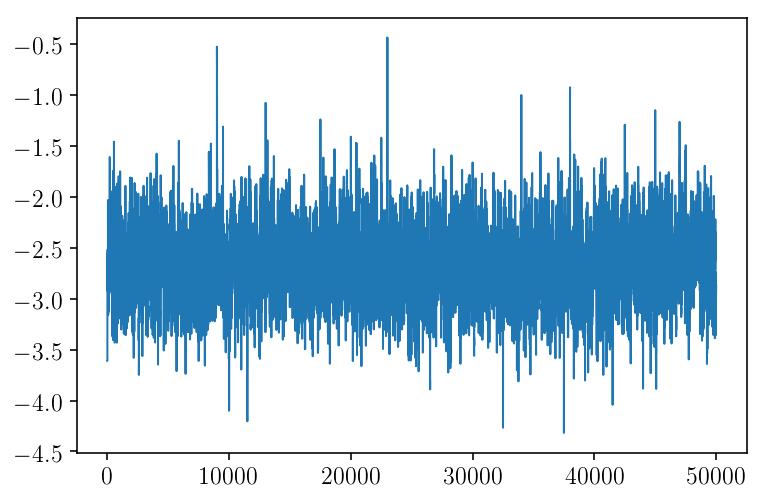

In [644]:
plt.plot(samples)

In [60]:
xyzgrid = np.mgrid[-30.:30.:100j,-30.:30.:100j,-30.:30.:100j]
print(np.shape(xyzgrid))
shape = np.shape(xyzgrid.T)
xyzgrid = xyzgrid.T.reshape(np.product(shape[:3]),shape[3])
rphizgrid = bovy_coords.rect_to_cyl(xyzgrid[:,0], xyzgrid[:,1], xyzgrid[:,2])
rphizgrid = np.dstack([rphizgrid[0],rphizgrid[1],rphizgrid[2]])[0]
rphizgrid = rphizgrid.reshape(100,100,100,3).T
print(np.shape(rphizgrid))
denstxyz = triaxial_powerlaw(rphizgrid[0],rphizgrid[1],rphizgrid[2], params=np.median(samples, axis=0))#np.median(samples, axis=0))
hdenstxyz = hernquist(rphizgrid[0],rphizgrid[1],rphizgrid[2], params=hernquist_par)
print(np.shape(denstxyz))

(3, 100, 100, 100)
(3, 100, 100, 100)
(100, 100, 100)


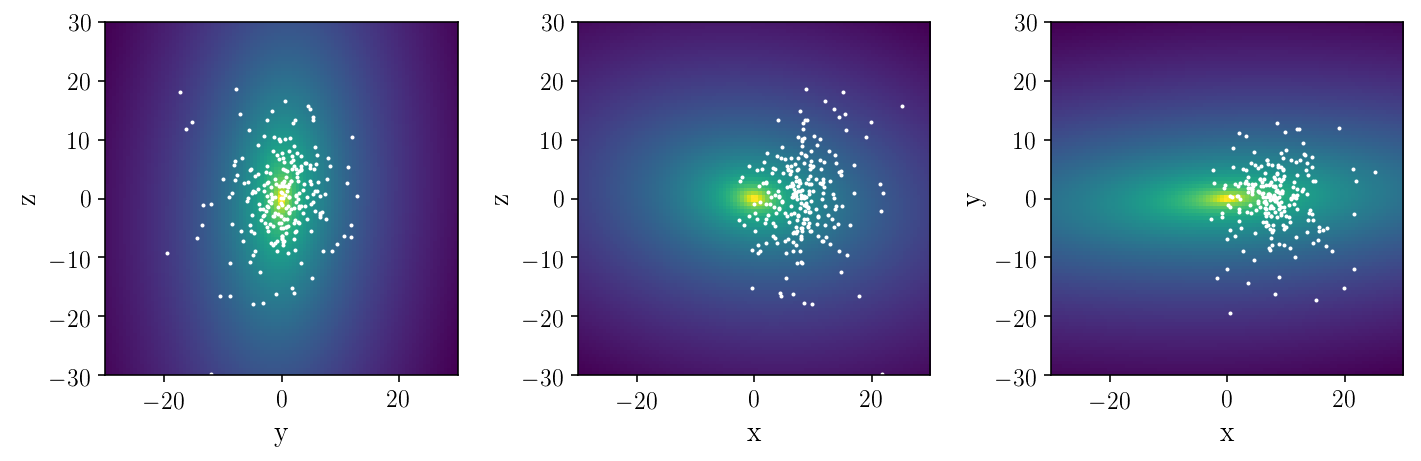

In [61]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(10,10)
ax[0].imshow(np.rot90(np.log10(np.sum(denstxyz, axis=0))), extent=[-30,30,-30,30])
ax[1].imshow(np.rot90(np.log10(np.sum(denstxyz, axis=1))), extent=[-30,30,-30,30])
ax[2].imshow(np.rot90(np.log10(np.sum(denstxyz, axis=2))), extent=[-30,30,-30,30])

xdat, ydat, zdat = bovy_coords.cyl_to_rect(Rphiz[:,0], Rphiz[:,1], Rphiz[:,2])
ax[0].scatter(ydat, zdat, s=1., color='White')
ax[1].scatter(xdat, zdat, s=1., color='White')
ax[2].scatter(xdat, ydat, s=1., color='White')

ax[0].set_xlabel(r'y')
ax[0].set_ylabel(r'z')
ax[1].set_xlabel(r'x')
ax[1].set_ylabel(r'z')
ax[2].set_xlabel(r'x')
ax[2].set_ylabel(r'y')

for axis in ax:
    axis.set_ylim(-30,30)
    axis.set_xlim(-30,30)
fig.tight_layout()

In [133]:
xyzgrid = np.mgrid[-30.:30.:100j,-30.:30.:100j,-30.:30.:100j]
print(np.shape(xyzgrid))
shape = np.shape(xyzgrid.T)
xyzgrid = xyzgrid.T.reshape(np.product(shape[:3]),shape[3])
rphizgrid = bovy_coords.rect_to_cyl(xyzgrid[:,0], xyzgrid[:,1], xyzgrid[:,2])
rphizgrid = np.dstack([rphizgrid[0],rphizgrid[1],rphizgrid[2]])[0]
rphizgrid = rphizgrid.reshape(100,100,100,3).T
print(np.shape(rphizgrid))
denstxyz = powerlaw_spherical(rphizgrid[0],rphizgrid[1],rphizgrid[2], params=powerlaw_par)#np.median(samples, axis=0))
hdenstxyz = hernquist(rphizgrid[0],rphizgrid[1],rphizgrid[2], params=hernquist_par)
print(np.shape(denstxyz))

(3, 100, 100, 100)
(3, 100, 100, 100)
(100, 100, 100)


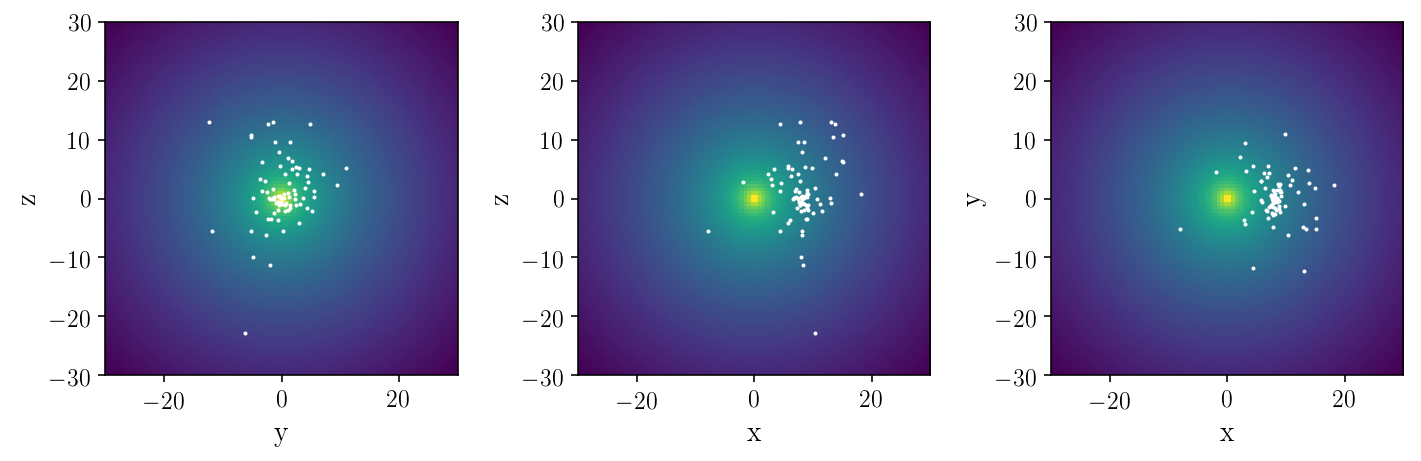

In [134]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(10,10)
ax[0].imshow(np.rot90(np.log10(np.sum(denstxyz, axis=0))), extent=[-30,30,-30,30])
ax[1].imshow(np.rot90(np.log10(np.sum(denstxyz, axis=1))), extent=[-30,30,-30,30])
ax[2].imshow(np.rot90(np.log10(np.sum(denstxyz, axis=2))), extent=[-30,30,-30,30])

xdat, ydat, zdat = bovy_coords.cyl_to_rect(Rphiz[:,0], Rphiz[:,1], Rphiz[:,2])
ax[0].scatter(ydat, zdat, s=1., color='White')
ax[1].scatter(xdat, zdat, s=1., color='White')
ax[2].scatter(xdat, ydat, s=1., color='White')

ax[0].set_xlabel(r'y')
ax[0].set_ylabel(r'z')
ax[1].set_xlabel(r'x')
ax[1].set_ylabel(r'z')
ax[2].set_xlabel(r'x')
ax[2].set_ylabel(r'y')

for axis in ax:
    axis.set_ylim(-30,30)
    axis.set_xlim(-30,30)
fig.tight_layout()

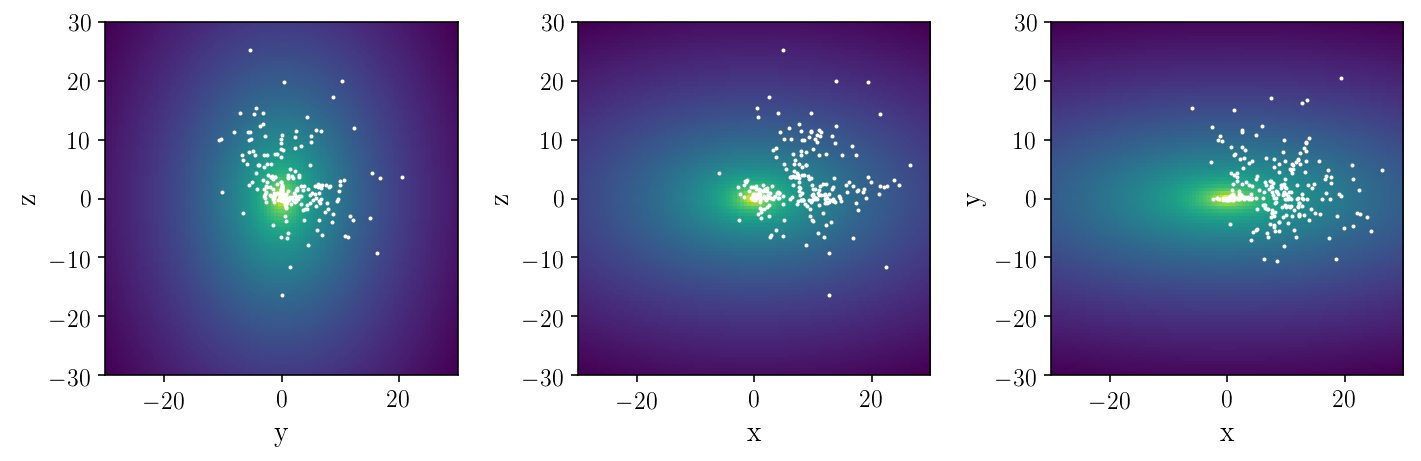

In [59]:
xyzgrid = np.mgrid[-30.:30.:100j,-30.:30.:100j,-30.:30.:100j]

shape = np.shape(xyzgrid.T)
xyzgrid = xyzgrid.T.reshape(np.product(shape[:3]),shape[3])
rphizgrid = bovy_coords.rect_to_cyl(xyzgrid[:,0], xyzgrid[:,1], xyzgrid[:,2])
rphizgrid = np.dstack([rphizgrid[0],rphizgrid[1],rphizgrid[2]])[0]
rphizgrid = rphizgrid.reshape(100,100,100,3).T

denstxyz = helmi(rphizgrid[0],rphizgrid[1],rphizgrid[2], params=helmi_par)#np.median(samples, axis=0))


fig, ax = plt.subplots(1,3)
fig.set_size_inches(10,10)
ax[0].imshow(np.rot90(np.log10(np.sum(denstxyz, axis=0))), extent=[-30,30,-30,30])
ax[1].imshow(np.rot90(np.log10(np.sum(denstxyz, axis=1))), extent=[-30,30,-30,30])
ax[2].imshow(np.rot90(np.log10(np.sum(denstxyz, axis=2))), extent=[-30,30,-30,30])

xdat, ydat, zdat = bovy_coords.cyl_to_rect(Rphiz[:,0], Rphiz[:,1], Rphiz[:,2])
ax[0].scatter(ydat, zdat, s=1., color='White')
ax[1].scatter(xdat, zdat, s=1., color='White')
ax[2].scatter(xdat, ydat, s=1., color='White')

ax[0].set_xlabel(r'y')
ax[0].set_ylabel(r'z')
ax[1].set_xlabel(r'x')
ax[1].set_ylabel(r'z')
ax[2].set_xlabel(r'x')
ax[2].set_ylabel(r'y')

for axis in ax:
    axis.set_ylim(-30,30)
    axis.set_xlim(-30,30)
fig.tight_layout()

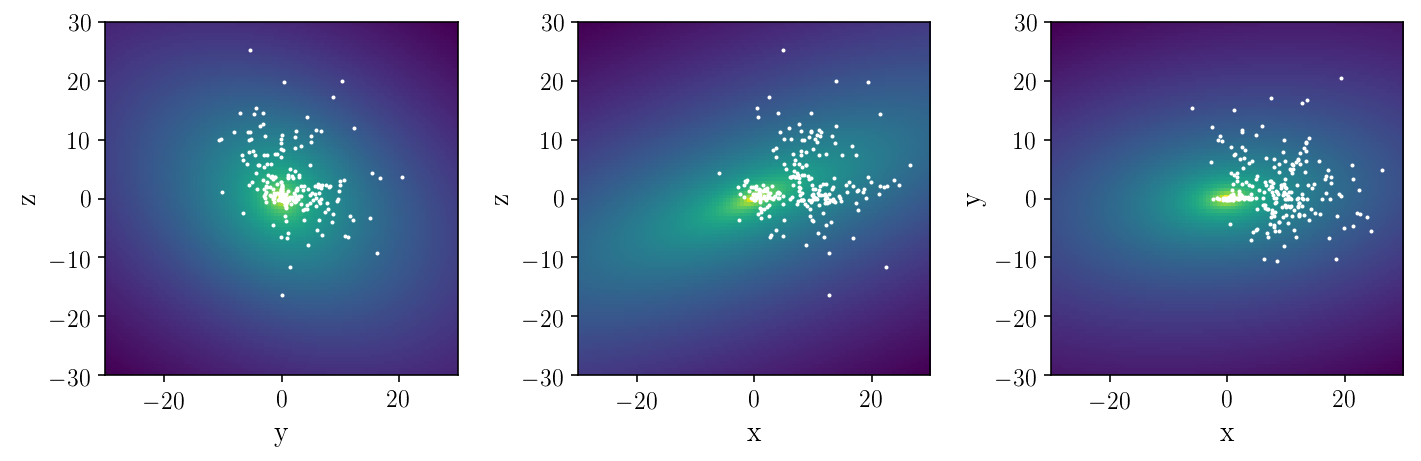

In [187]:
xyzgrid = np.mgrid[-30.:30.:100j,-30.:30.:100j,-30.:30.:100j]

shape = np.shape(xyzgrid.T)
xyzgrid = xyzgrid.T.reshape(np.product(shape[:3]),shape[3])
rphizgrid = bovy_coords.rect_to_cyl(xyzgrid[:,0], xyzgrid[:,1], xyzgrid[:,2])
rphizgrid = np.dstack([rphizgrid[0],rphizgrid[1],rphizgrid[2]])[0]
rphizgrid = rphizgrid.reshape(100,100,100,3).T

denstxyz = helmi(rphizgrid[0],rphizgrid[1],rphizgrid[2], params=np.median(samples, axis=0))


fig, ax = plt.subplots(1,3)
fig.set_size_inches(10,10)
ax[0].imshow(np.rot90(np.log10(np.sum(denstxyz, axis=0))), extent=[-30,30,-30,30])
ax[1].imshow(np.rot90(np.log10(np.sum(denstxyz, axis=1))), extent=[-30,30,-30,30])
ax[2].imshow(np.rot90(np.log10(np.sum(denstxyz, axis=2))), extent=[-30,30,-30,30])

xdat, ydat, zdat = bovy_coords.cyl_to_rect(Rphiz[:,0], Rphiz[:,1], Rphiz[:,2])
ax[0].scatter(ydat, zdat, s=1., color='White')
ax[1].scatter(xdat, zdat, s=1., color='White')
ax[2].scatter(xdat, ydat, s=1., color='White')

ax[0].set_xlabel(r'y')
ax[0].set_ylabel(r'z')
ax[1].set_xlabel(r'x')
ax[1].set_ylabel(r'z')
ax[2].set_xlabel(r'x')
ax[2].set_ylabel(r'y')

for axis in ax:
    axis.set_ylim(-30,30)
    axis.set_xlim(-30,30)
fig.tight_layout()

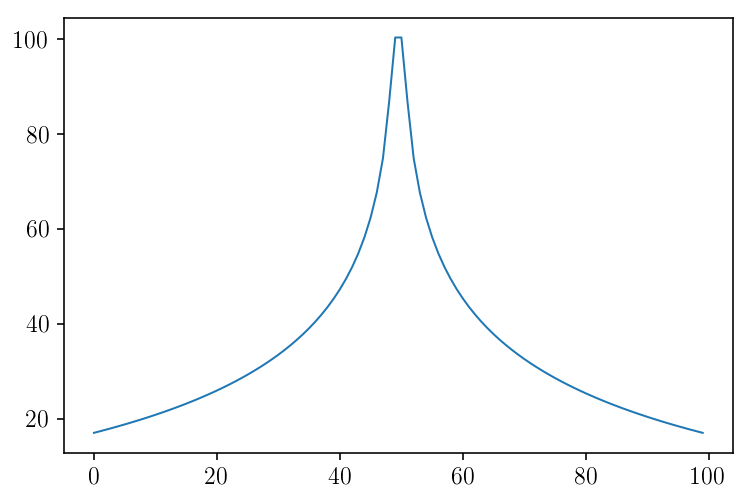

In [188]:
plt.plot(np.sum(np.sum(denstxyz, axis=2),axis=1))


In [59]:

Rgrid, phigrid, zgrid = Rphizgrid(apo,distmods)

In [70]:

effdens = tdens(exponential,Rgrid,phigrid,zgrid,params=[1/2.])
effvol = np.sum(effdens*outarea)

In [112]:
txyz = bovy_coords.galcencyl_to_XYZ(Rphiz[:,0], Rphiz[:,1], Rphiz[:,2], Xsun=8., Zsun=0.02)
galcenrect = bovy_coords.XYZ_to_galcenrect(txyz[:,0], txyz[:,1], txyz[:,2], Xsun=8., Zsun=0.02)

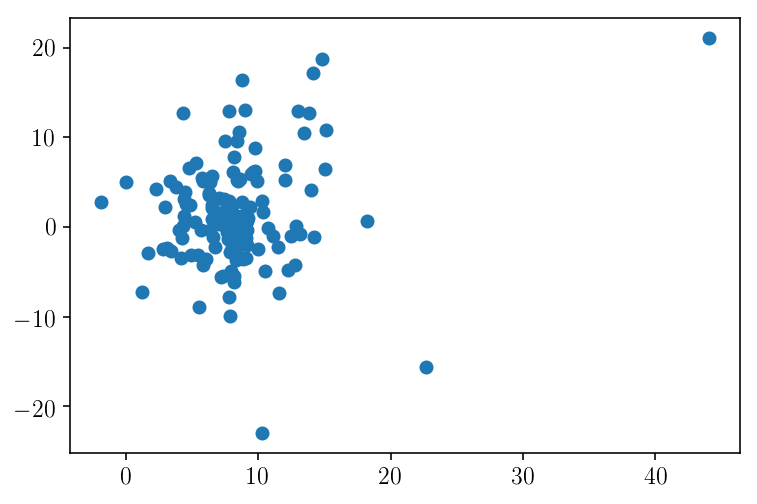

In [113]:
plt.scatter(galcenrect[:,0], galcenrect[:,2])

In [71]:
effvol

57774.225178257286

(array([327046.7665467 , 163887.49230678, 191755.90240961, 120949.54066666,
        158558.77342627, 169935.88666261, 163256.46222894, 164801.15938623,
        159267.75438594, 162444.64206609]),
 array([-1.5797836 , -1.37186547, -1.16394735, -0.95602922, -0.7481111 ,
        -0.54019297, -0.33227485, -0.12435672,  0.0835614 ,  0.29147952,
         0.49939765]),
 <a list of 10 Patch objects>)

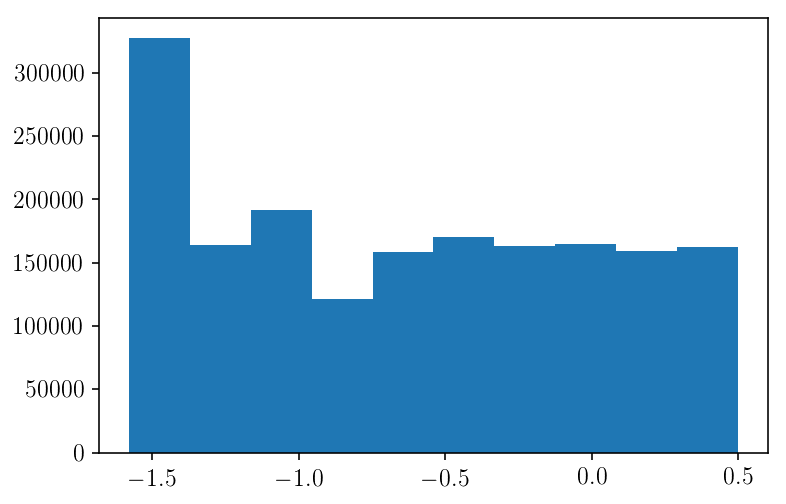

In [95]:
plt.hist(Z2FEH(trec['Z']), weights=weights)

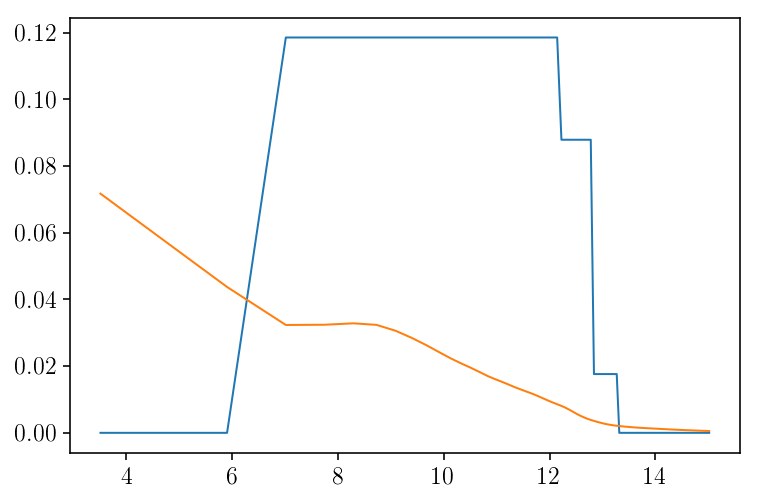

In [99]:
hmag = 5*np.log10(dists*1e3)-5-1.49
plt.plot(hmag, apo(apo._locations[i], hmag, JK0=np.ones(len(hmag))*0.6))
plt.plot(hmag, effsel)

In [100]:
[apo.JKmin(apo._locations[i]) for i in range(len(apo._locations))]

[0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5

In [35]:
dmap.dust_vals_disk?

In [72]:
location = apo._locations[0]
jkbins = [apo.JKmin(location,bin=i) for i in range(apo.NColorBins(location))]

In [73]:
jkbins

[0.5]

In [78]:
np.where(np.array(0.2) > jkbins )[0][0]

IndexError: index 0 is out of bounds for axis 0 with size 0

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,

In [35]:
from isodist.imf import lognormalChabrier2001

def sample_isochrones(N, )

imf = lognormalChabrier2001

masses = np.linspace(np.min(trec['M_ini']),np.max(trec['M_ini']),100)

im = imf(masses)
im[0] = 0.
mask = (trec['M_ini'] > 0.75) & (trec['J']-trec['K'] > 0.5) & (Z2FEH(trec['Z']) > -1.5) & (Z2FEH(trec['Z']) < -1.)
masses = np.linspace(np.min(trec[mask]['M_ini']),np.max(trec[mask]['M_ini']),100)

inter = interp1d(np.cumsum(im)/np.sum(im), masses)

N = 1000
min_feh = -1.5
max_feh = -1.
min_age = 0.
max_age = 13.
random_mass = inter(np.random.rand(N))
random_age = np.random.rand(N)*(np.fabs(max_age)-np.fabs(min_age))+(min_age)
random_feh = np.random.rand(N)*(np.fabs(max_feh)-np.fabs(min_feh))+(max_feh)
inds = np.zeros(len(random_mass), dtype=np.int64)

def find_one_ind(i):
    dists = np.fabs(trec['logageyr'][mask] - np.log10(random_age[i]*1e9)) +\
            np.fabs(trec['Z'][mask] - FEH2Z(random_feh[i])) +\
            np.fabs(trec['M_ini'][mask] - random_mass[i])
    return np.argmin(dists)

with multiprocessing.Pool(int(multiprocessing.cpu_count()//4)) as p:
    inds = list(tqdm.tqdm_notebook(p.imap(find_one_ind, range(0,len(random_mass))), total=len(random_mass)))
inds = np.array(inds, dtype=np.int64)



HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

In [47]:
np.median(allstar['K_ERR'])

0.021

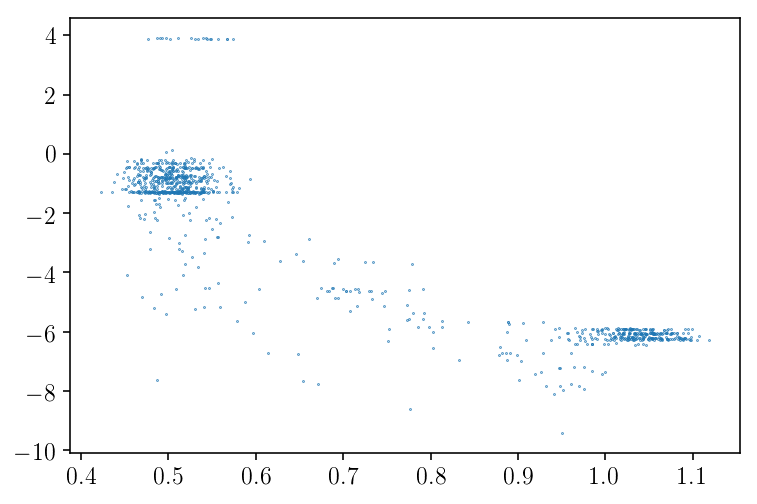

In [48]:
jerr, herr, kerr = np.random.randn(len(trec[mask][inds]))*0.02, np.random.randn(len(trec[mask][inds]))*0.02, np.random.randn(len(trec[mask][inds]))*0.02
plt.scatter(trec[mask][inds]['J']+jerr-trec[mask][inds]['K']+kerr, trec[mask][inds]['H']+herr, s=0.1)

(array([121.,  49., 236., 100.,  41., 108.,  51., 144.,  95.,  55.]),
 array([ 0.01412538,  1.27163825,  2.52915112,  3.786664  ,  5.04417687,
         6.30168975,  7.55920262,  8.8167155 , 10.07422837, 11.33174124,
        12.58925412]),
 <a list of 10 Patch objects>)

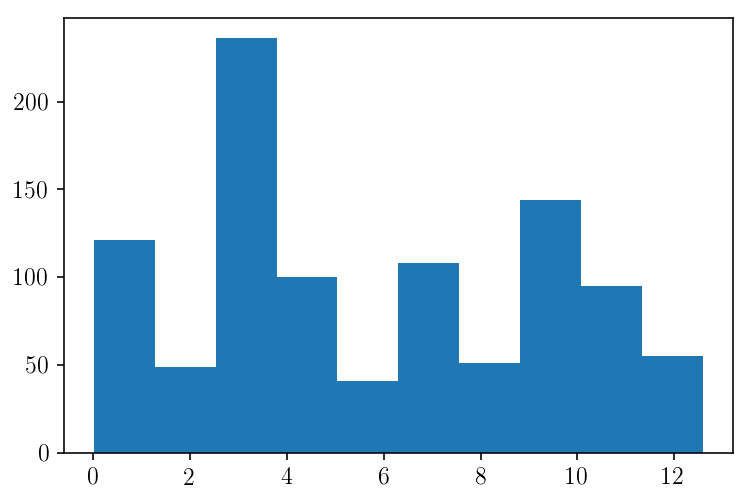

In [49]:
plt.hist(10**(trec[mask][inds]['logageyr']-9))

(array([590.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 410.]),
 array([-1.2787536 , -1.26114448, -1.24353535, -1.22592622, -1.2083171 ,
        -1.19070797, -1.17309885, -1.15548972, -1.13788059, -1.12027147,
        -1.10266234]),
 <a list of 10 Patch objects>)

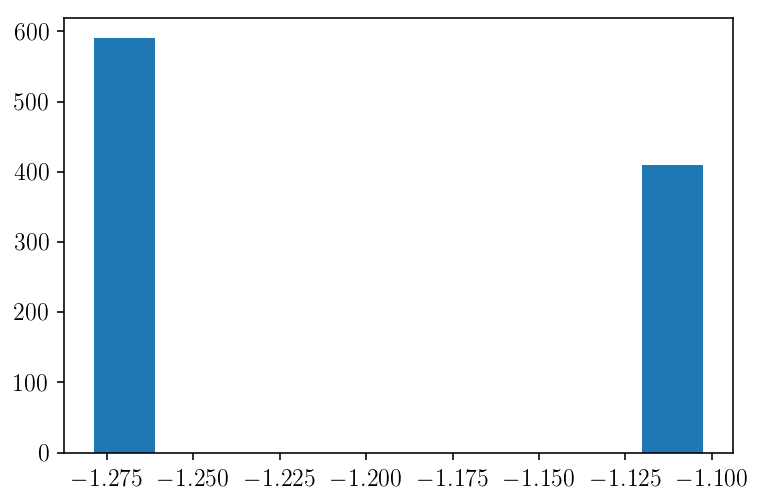

In [44]:
plt.hist(Z2FEH(trec[mask]['Z'][inds]))

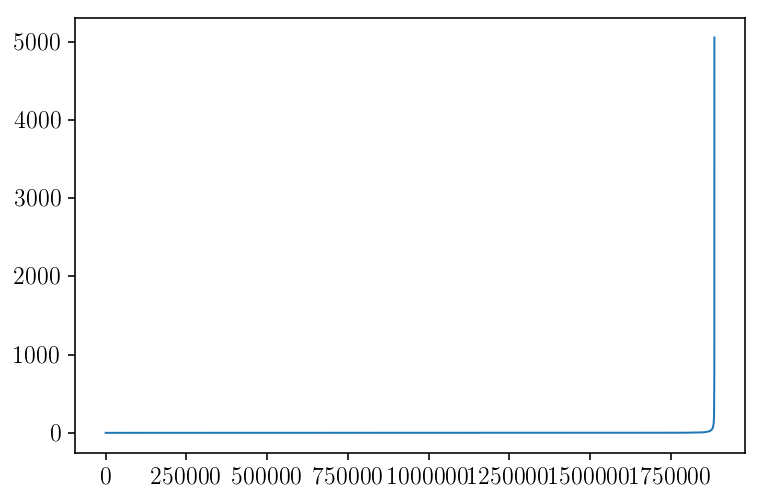

In [76]:
ws = trec['deltaM']*(10**(trec['logageyr']-9)/trec['Z'])
sort = np.argsort(ws)
mask = (trec['M_ini'][sort] > 0.75) #& (isochrones['H'][sort] > -4.)
plt.plot(ws[sort])

In [239]:
np.cumsum(ws[sort])

array([1.05213128e-01, 2.12131048e-01, 3.19296290e-01, ...,
       8.91676253e+08, 8.91753596e+08, 8.91830940e+08])

In [247]:
print(trec['logageyr'][trec['deltaM'] < 0])
print(trec['Z'][trec['deltaM'] < 0])

[ 6.65  6.65  6.65 ... 10.1  10.1  10.1 ]
[0.0285 0.029  0.0295 ... 0.0405 0.041  0.0415]


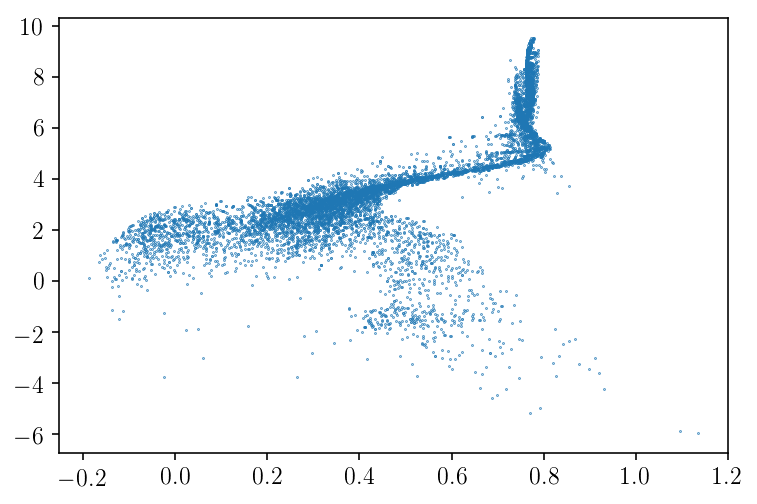

/home/astjmack/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "



(array([0.06938268, 0.08044323, 0.08177812, 0.08622777]),
 array([3.98107171e-03, 3.15029933e+00, 6.29661759e+00, 9.44293586e+00,
        1.25892541e+01]),
 <a list of 1 Patch objects>)

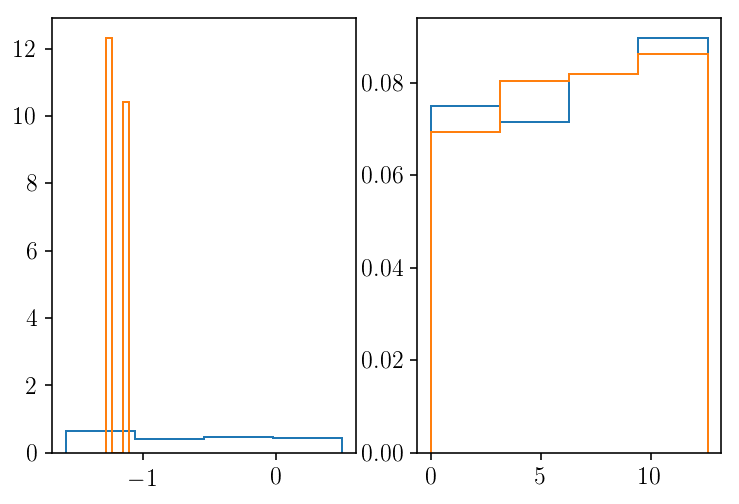

In [122]:
ws = trec['deltaM']*(10**(trec['logageyr']-9)/trec['Z'])
fig, ax = plt.subplots(1,2)
ax[0].hist(Z2FEH(trec['Z']), weights=ws, bins=4, histtype='step', normed=True)
ax[1].hist(10**(trec['logageyr']-9), weights=ws, bins=4, histtype='step', normed=True)
ax[0].hist(Z2FEH(niso['Z']), bins=4, histtype='step', normed=True)
ax[1].hist(10**(niso['logageyr']-9), bins=4, histtype='step', normed=True)



(array([ 566.,  693.,  745., 1036.,  461., 1115.,  687., 1925., 1192.,
        1580.]),
 array([7.07945784e-03, 1.26529692e+00, 2.52351439e+00, 3.78173186e+00,
        5.03994932e+00, 6.29816679e+00, 7.55638425e+00, 8.81460172e+00,
        1.00728192e+01, 1.13310367e+01, 1.25892541e+01]),
 <a list of 10 Patch objects>)

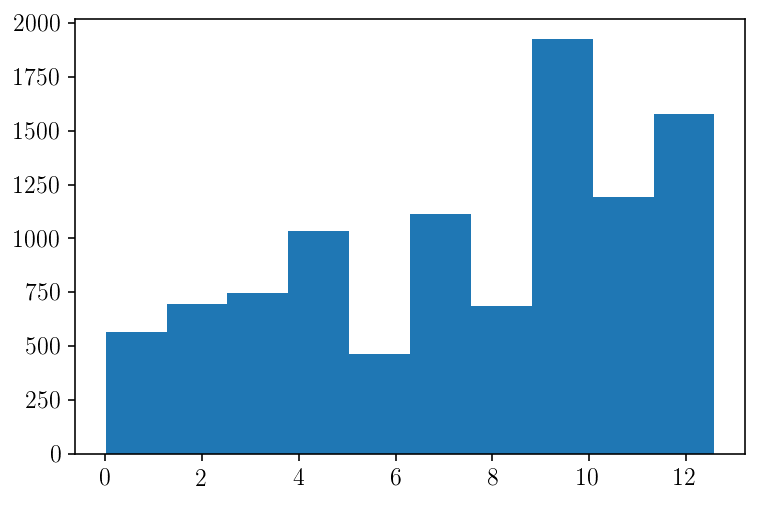

In [206]:
plt.hist(10**(trec[inds]['logageyr'])/1e9)

In [188]:
weights = trec['int_IMF']*(10**(trec['logageyr']-9))/trec['Z']
sort = np.argsort(weights)
tinter = interp1d(np.cumsum(weights[sort])/np.sum(weights), range(len(weights[sort])), kind='linear')

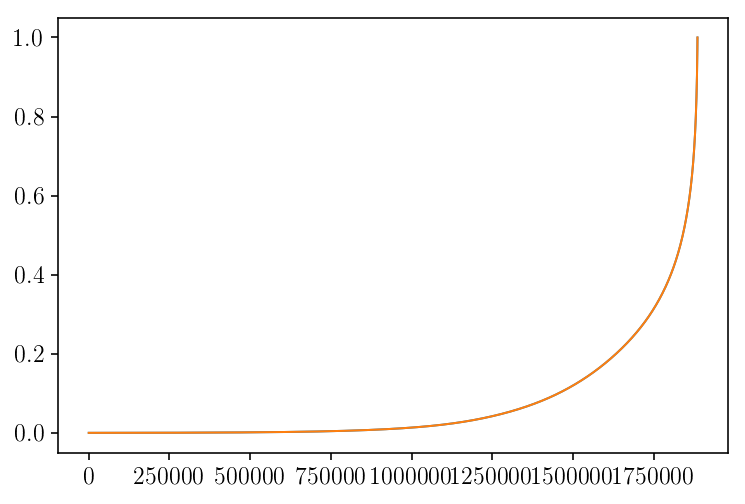

In [189]:
plt.plot( range(len(weights[sort])), np.cumsum(weights[sort])/np.sum(weights),)
plt.plot(tinter(np.cumsum(weights[sort])/np.sum(weights)),  np.cumsum(weights[sort])/np.sum(weights))

In [101]:
randinds = np.round(tinter(np.random.rand(100))).astype(np.int64)

In [900]:
rate = powerlaw_spherical(Rgrid[goodfields],phigrid[goodfields],zgrid[goodfields],params=[np.median(samples)])*outarea[goodfields]*ds**2.*(distmods[1]-distmods[0])*(ds*np.log(10)/5.)
sumrate = np.sum(rate)

norm = len(Rphiz)/sumrate

isomask = (Z2FEH(trec['Z']) < -1.) & (Z2FEH(trec['Z']) > -1.5) & (trec['J']-trec['K'] > 0.5)

avmass = average_mass(trec[isomask])

isomask = (Z2FEH(trec['Z']) < -1.) & (Z2FEH(trec['Z']) > -1.5)

massratio = mass_ratio(trec[isomask])

In [901]:
massratio

0.008060102440155424

In [902]:
avmass/massratio

33.46552467951847

In [903]:
fac = norm*(180/np.pi)**2*avmass/massratio #M_sun pc^-3 ???

In [904]:
from scipy.integrate import nquad

In [905]:
xyzgrid = np.mgrid[-100.:100.:150j,-100.:100.:150j,-100.:100.:150j]
delta = xyzgrid[0,:,0,0][1]-xyzgrid[0,:,0,0][0]
print(np.shape(xyzgrid))
shape = np.shape(xyzgrid.T)
xyzgrid = xyzgrid.T.reshape(np.product(shape[:3]),shape[3])
rphizgrid = bovy_coords.rect_to_cyl(xyzgrid[:,0], xyzgrid[:,1], xyzgrid[:,2])
rphizgrid = np.dstack([rphizgrid[0],rphizgrid[1],rphizgrid[2]])[0]
rphizgrid = rphizgrid.reshape(150,150,150,3).T
masses = np.zeros(400)
for ii,power in tqdm.tqdm_notebook(enumerate(samples[np.random.randint(len(samples), size=400)]), total=400):
    denstxyz = powerlaw_spherical(rphizgrid[0],rphizgrid[1],rphizgrid[2], params=[power])*fac
    masses[ii] =  np.sum(denstxyz)*(delta*delta*delta)

print(np.shape(denstxyz))

(3, 150, 150, 150)


HBox(children=(IntProgress(value=0, max=400), HTML(value='')))

(150, 150, 150)


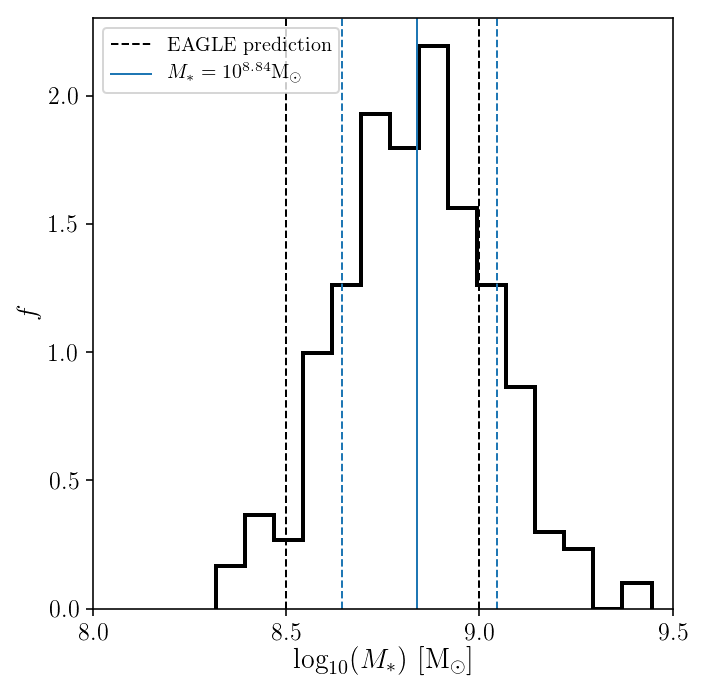

In [908]:
fig = plt.figure()
fig.set_size_inches(1.5*columnwidth,1.5*columnwidth)
plt.hist(np.log10(masses), histtype='step', lw=2., color='Black', density=True, bins=15)
plt.axvline(8.5, color='Black', linestyle='dashed', label=r'$\mathrm{EAGLE\ prediction}$')
plt.axvline(9., color='Black', linestyle='dashed')
plt.axvline(np.log10(np.median(masses)), label=r'$M_* = 10^{'+str(round(np.log10(np.median(masses)),2))+r'}\mathrm{M_{\odot}}$')
plt.axvline(np.log10(np.percentile(masses, 16)), linestyle='dashed')
plt.axvline(np.log10(np.percentile(masses, 84)), linestyle='dashed')
plt.xticks([8.,8.5,9.,9.5])
plt.xlabel(r'$\log_{10}(M_*)\ \mathrm{[M_{\odot}]}$')
plt.ylabel(r'$f$')
plt.legend()
fig.tight_layout()
#plt.savefig('../plots/powerlaw_spherical_mass_post.pdf', format='pdf')
#plt.savefig('../plots/powerlaw_spherical_mass_post.png', format='png', dpi=400)

In [ ]:
gaiaxmatch = fits.open('/gal/GAIA/APOGEE_l31c_58297_GaiaXmatch.fits')[1].data

from astropy.table import Table, join
distances = fits.open('/gal/GAIA/monoage-velocity-dispersion/sav/apogee_dr14_nn_dist_new.fits')[1].data
tab1 = Table(data = allstar[statindx & accreted])
#tab2 = Table(data= gaiaxmatch)
tab2 = Table(data=distances)

matched = join(tab1,tab2)

ra, dec, parallax, pmra, pmdec, RV = matched['ra'], matched['dec'], matched['parallax'], matched['pmra'], matched['pmdec'], matched['VHELIO_AVG']
radec, raparallax, rapmra, rapmdec = matched['ra_dec_corr'], matched['ra_parallax_corr'], matched['ra_pmra_corr'], matched['ra_pmdec_corr']
decparallax, decpmra, decpmdec = matched['dec_parallax_corr'], matched['dec_pmra_corr'], matched['dec_pmdec_corr']
parallaxpmra, parallaxpmdec = matched['parallax_pmra_corr'], matched['parallax_pmdec_corr']
pmrapmdec = matched['pmra_pmdec_corr']
ra_e, dec_e, parallax_e, pmra_e, pmdec_e, RV_e = matched['ra_error'], matched['dec_error'], matched['parallax_error'], matched['pmra_error'], matched['pmdec_error'], matched['VERR']
cov = np.zeros([len(matched),6,6])
cov[:,0] = np.dstack([ra_e**2, ra_e*dec_e*radec, ra_e*parallax_e*raparallax, ra_e*pmra_e*rapmra, ra_e*dec_e*rapmdec, np.zeros(len(matched))])[0]
cov[:,1,1:] = np.dstack([dec_e**2, dec_e*parallax_e*decparallax, dec_e*pmra_e*decpmra, dec_e*pmdec_e*decpmdec, np.zeros(len(matched))])[0]
cov[:,2,2:] = np.dstack([parallax_e**2, parallax_e*pmra_e*parallaxpmra, parallax_e*pmdec_e*parallaxpmdec, np.zeros(len(matched))])[0]
cov[:,3,3:] = np.dstack([pmra_e**2, pmra_e*pmdec_e*pmrapmdec, np.zeros(len(matched))])[0]
cov[:,4,4:] = np.dstack([pmdec_e**2, np.zeros(len(matched))])[0]
cov[:,5,5] = RV_e**2
cov[:,:,0] = cov[:,0]
cov[:,1:,1] = cov[:,1,1:]
cov[:,2:,2] = cov[:,2,2:]
cov[:,3:,3] = cov[:,3,3:]
cov[:,4:,4] = cov[:,4,4:]

mean = np.dstack([ra,dec,parallax,pmra,pmdec,RV])[0]

omask = np.all(np.isfinite(mean), axis=1) & (np.all(np.isfinite(mean), axis=1))
sampled_vxvv = np.empty((len(matched[omask]),100,6))
for i in tqdm.tqdm_notebook(range(len(matched[omask]))):
    try:
        sampled_vxvv[i] = np.random.multivariate_normal(mean[omask][i], cov[omask][i], 100)
    except ValueError:
        print(mean[omask][i])
        print(cov[omask][i])
        
sampled_vxvv = sampled_vxvv.reshape(len(matched[omask])*100,6)
zo = 0.02
ro = 8.
vo=220.
vxvv = np.copy(sampled_vxvv)
ra, dec= vxvv[:,0], vxvv[:,1]
lb= bovy_coords.radec_to_lb(ra,dec,degree=True)
pmra, pmdec= vxvv[:,3], vxvv[:,4]
pmllpmbb= bovy_coords.pmrapmdec_to_pmllpmbb(pmra,pmdec,ra,dec,degree=True)
d, vlos= vxvv[:,2], vxvv[:,5]
d = 1./d
rectgal= bovy_coords.sphergal_to_rectgal(lb[:,0],lb[:,1],d,vlos,pmllpmbb[:,0], pmllpmbb[:,1],degree=True)
vsolar= np.array([-11.1,245.6,7.25]) #use SBD10 vR and vZ and SGR proper motion vT
vsun= np.array([0.,0.,0.,])+vsolar/vo
X = rectgal[:,0]/ro
Y = rectgal[:,1]/ro
Z = rectgal[:,2]/ro
vx = rectgal[:,3]/vo
vy = rectgal[:,4]/vo
vz = rectgal[:,5]/vo
XYZ = np.dstack([X, Y, Z])[0]
vxyz = np.dstack([vx,vy,vz])[0]

Rpz = bovy_coords.XYZ_to_galcencyl(XYZ[:,0],XYZ[:,1],XYZ[:,2],Zsun=zo/ro)
vRvTvz = bovy_coords.vxvyvz_to_galcencyl(vxyz[:,0], vxyz[:,1], vxyz[:,2], Rpz[:,0], Rpz[:,1], Rpz[:,2],
                                                            vsun=vsun,
                                                            Xsun=1.,
                                                            Zsun=zo/ro,
                                                            galcen=True)


vxvv = np.dstack([Rpz[:,0], vRvTvz[:,0], vRvTvz[:,1], Rpz[:,2], vRvTvz[:,2], Rpz[:,1]])[0]


os = Orbits(vxvv)

es = os.e(analytic=True, pot=MWPotential2014)
rperi = os.rperi(analytic=True, pot=MWPotential2014)
rap = os.rap(analytic=True, pot=MWPotential2014)
zmax = os.zmax(analytic=True, pot=MWPotential2014)

rperi = np.array(rperi).reshape(len(matched[omask]),100)
rap = np.array(rap).reshape(len(matched[omask]),100)
zmax = np.array(zmax).reshape(len(matched[omask]),100)
es = np.array(es).reshape(len(matched[omask]),100)

plt.hist(np.mean(es, axis=1), range=[0.,1.])

In [ ]:


def tdens(densfunc, Rgrid, phigrid, zgrid, params=None):
    if params is None:
        dens = densfunc(Rgrid,phigrid,zgrid)
    else:
        dens = densfunc(Rgrid,phigrid,zgrid,params=params)
    return dens

def effvol(densfunc, effsel, Rgrid, phigrid, zgrid, params=None):
    if params is None:
        effdens = tdens(densfunc,Rgrid,phigrid,zgrid)
    else:
        effdens = tdens(densfunc,Rgrid,phigrid,zgrid,params=params)
    return np.sum(effdens*effsel)
    
def loglike(params, densfunc, effsel, Rgrid, phigrid, zgrid, dataR, dataphi, dataz):
    if not check_prior(densfunc, params):
        return -np.inf
    logdatadens = np.log(tdens(densfunc, dataR, dataphi, dataz, params=params))
    logeffvol = np.log(effvol(densfunc,effsel,Rgrid,phigrid,zgrid,params=params))
    return np.sum(logdatadens)-len(dataR)*logeffvol

In [526]:
flattened_model = """
functions {
    vector density(int ndata, vector R, vector phi, vector z, real alpha,real a,real c) {
            vector[ndata] dens;
            real r0;
            real tr0;
            r0 = sqrt(8.^2+0.02^2);
            for (i in 1:ndata) {
                real r;
                real x;
                real y;
                x = R[i]*cos(phi[i]);
                y = R[i]*sin(phi[i]);
                r = x^2+y^2+z[i]^2/c^2+a^2;
                dens[i] = r0^alpha/r^alpha;
                }
            return dens;
            }
}
data {
    int<lower=0> ndistmods;
    int<lower=0> nfields;
    int<lower=0> ndata;
    vector[ndistmods] Rgrid[nfields];
    vector[ndistmods] phigrid[nfields];
    vector[ndistmods] zgrid[nfields];
    vector[ndistmods] effsel[nfields];
    vector[ndata] dataR;
    vector[ndata] dataphi;
    vector[ndata] dataz;
    
}
parameters {
    real<lower=0,upper=10.> alpha;
    real<lower=0.,upper=10.> a;
    real<lower=0.,upper=1.> c;
}
model {
    real datadens;
    vector[nfields] effvol_fields;
    c ~ normal(0.5,0.5);
    datadens = log(sum(density(ndata, dataR, dataphi, dataz, alpha,a,c)));
    for (i in 1:nfields) {
        effvol_fields[i] = sum(density(ndistmods, Rgrid[i], phigrid[i], zgrid[i], alpha, a,c).*effsel[i]);
    }
    target += datadens-ndata*log(sum(effvol_fields));
}
"""

model = """
functions {
    vector density(int ndata, vector R, vector phi, vector z, real alpha) {
            vector[ndata] dens;
            real r0;
            r0 = sqrt(8.^2+0.02^2);
            for (i in 1:ndata) {
                real r;
                r = sqrt(R[i]^2+z[i]^2);
                dens[i] = r0^alpha/(r^alpha);
                }
            return dens;
            }
}
data {
    int<lower=0> ndistmods;
    int<lower=0> nfields;
    int<lower=0> ndata;
    vector[ndistmods] Rgrid[nfields];
    vector[ndistmods] phigrid[nfields];
    vector[ndistmods] zgrid[nfields];
    vector[ndistmods] effsel[nfields];
    vector[ndata] dataR;
    vector[ndata] dataphi;
    vector[ndata] dataz;
    
}
parameters {
    real<lower=0,upper=10.> alpha;
}
model {
    real datadens;
    vector[nfields] effvol_fields;
    datadens = log(sum(density(ndata, dataR, dataphi, dataz, alpha)));
    for (i in 1:nfields) {
        effvol_fields[i] = sum(density(ndistmods, Rgrid[i], phigrid[i], zgrid[i], alpha).*effsel[i]);
    }
    target += datadens-ndata*log(sum(effvol_fields));
}
"""

In [527]:
import pystan

In [531]:
sm = pystan.StanModel(model_code=model, verbose=True)

Compiling /tmp/tmp9ixzqn4n/stanfit4anon_model_5f6f91e4abf63a0b34d502106af12819_3748200649532912970.pyx because it changed.
[1/1] Cythonizing /tmp/tmp9ixzqn4n/stanfit4anon_model_5f6f91e4abf63a0b34d502106af12819_3748200649532912970.pyx
building 'stanfit4anon_model_5f6f91e4abf63a0b34d502106af12819_3748200649532912970' extension
creating /tmp/tmp9ixzqn4n/tmp
creating /tmp/tmp9ixzqn4n/tmp/tmp9ixzqn4n
gcc -pthread -B /home/astjmack/anaconda3/compiler_compat -Wl,--sysroot=/ -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -I/home/astjmack/.local/include -fPIC -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -I/tmp/tmp9ixzqn4n -I/home/astjmack/anaconda3/lib/python3.6/site-packages/pystan -I/home/astjmack/anaconda3/lib/python3.6/site-packages/pystan/stan/src -I/home/astjmack/anaconda3/lib/python3.6/site-packages/pystan/stan/lib/stan_math -I/home/astjmack/anaconda3/lib/python3.6/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3 -I/home/astjmack/anaconda3/lib/python3.6

In [532]:
in_data ={'ndistmods': np.shape(effsel_in)[1],
          'nfields': np.shape(effsel_in)[0],
          'ndata': np.shape(Rphiz)[0],
          'Rgrid': Rgrid_in,
          'phigrid': phigrid_in,
          'zgrid': zgrid_in,
          'effsel': effsel_in,
          'dataR': Rphiz[:,0],
          'dataphi': Rphiz[:,1],
          'dataz': Rphiz[:,2]}

fit = sm.sampling(data=in_data, iter=400, chains=4)

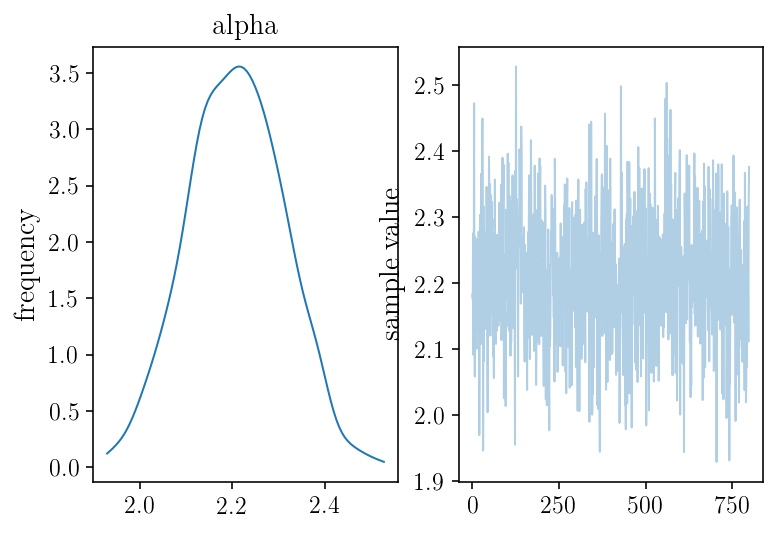

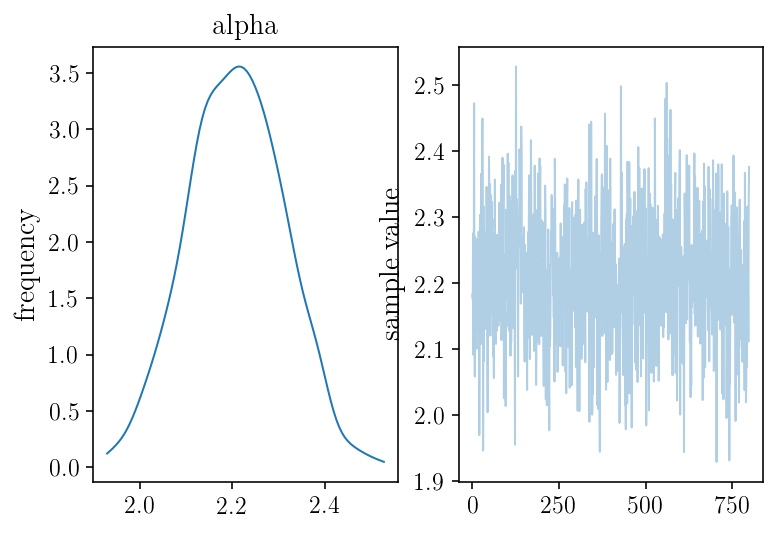

In [533]:
fit.plot()


array([3.02730243e-03, 1.44039024e-04, 3.78205354e-03, 1.43636123e-03,
       6.22991168e-04, 3.35369058e-03, 1.64934660e-03, 1.02297723e-03,
       1.17821804e-04, 2.83071617e-03, 1.21832372e-03, 8.06226013e-04,
       2.82758393e-04, 2.48259703e-03, 1.15188860e-04, 1.01258717e-03,
       1.89808674e-03, 1.50828437e-03, 1.03732860e-03, 1.53586417e-03,
       8.63548434e-04, 8.04363089e-04, 5.62884493e-04, 9.89737507e-04,
       8.46540492e-04, 1.78058966e-03, 9.71657260e-04, 2.55105408e-03,
       2.38916196e-03, 2.01021459e-03, 1.14458553e-03, 2.19760354e-03,
       8.92919742e-04, 6.48360111e-04, 1.08238095e-03, 1.76523305e-03,
       1.28392809e-03, 1.13138127e-03, 1.39562343e-03, 1.63576235e-03,
       1.81431977e-03, 2.32507657e-03, 1.16633907e-03, 2.00923042e-03,
       1.17080475e-03, 7.10505572e-04, 1.54630472e-03, 8.53974862e-04,
       1.53752994e-03, 1.06899539e-03, 8.55595906e-04, 1.59935434e-03,
       1.36168390e-03, 2.56128835e-03, 1.40677195e-03, 1.91705558e-03,
      

In [281]:
in_data['ndistmods']

301

In [267]:
effsel_in

array([[7.57060848e-06, 8.36701772e-06, 9.67349187e-06, ...,
        1.29803266e+01, 1.27196311e+01, 1.24257272e+01],
       [1.63975774e-05, 1.92930793e-05, 2.30248128e-05, ...,
        1.28050906e+02, 1.29405945e+02, 1.32003454e+02],
       [2.87932754e-07, 3.14600822e-07, 3.59586205e-07, ...,
        2.56628004e-04, 2.39967001e-04, 2.20881619e-04],
       ...,
       [2.80673936e-05, 3.25466721e-05, 3.74071856e-05, ...,
        4.33605229e+00, 4.17505154e+00, 4.12488848e+00],
       [9.56277869e-06, 1.14649176e-05, 1.32721850e-05, ...,
        5.17243507e+00, 4.85996271e+00, 4.72327786e+00],
       [1.62510551e-05, 1.90671041e-05, 2.28650346e-05, ...,
        1.35429116e+01, 1.33395459e+01, 1.11413359e+01]])

In [336]:
def standens(in_data):
    alpha = 0.1
    tdens = 0
    for f in range(in_data['nfields']):
        dens = np.zeros(in_data['ndistmods'])
        for i in range(in_data['ndistmods']): 
            r = np.sqrt(in_data['Rgrid'][f][i]**2+in_data['zgrid'][f][i]**2)
            dens[i] = 1/(r**alpha)
        tdens += np.sum(dens)
    return tdens

In [337]:
standens(in_data)

109063.15816797777

In [487]:
def powerlaw_spherical(R,phi,z, params=[2.,]):
    r = np.sqrt(R**2+z**2)
    r0 = np.sqrt(8.**2+0.02**2)
    dens = r0**params[0]/r**params[0]
    return dens



from scipy import interpolate
rate = powerlaw_spherical(Rgrid[goodfields],phigrid[goodfields],zgrid[goodfields],params=[np.mean(fit.extract()['alpha']),])*outarea[goodfields]*distmods**3*(distmods[1]-distmods[0])
out = np.zeros((len(rate), len(distmods)))
for i in range(len(rate)):
    tjac = np.ones_like(distmods)
    tXs = distmods[rate[ii] > 0.]
    sindx =np.argsort(tXs)
    tXs = tXs[sindx]
    trate = rate[ii,rate[ii] > 0.][sindx]
    tjac= tjac[rate[ii] > 0.][sindx]
    ipthis= np.log(trate*tjac+10.**-8.)
    baseline= np.polynomial.Polynomial.fit(tXs,ipthis,4)
    ipthis= ipthis/baseline(tXs)
    sp= interpolate.InterpolatedUnivariateSpline(tXs,ipthis,k=3)
    tindx= (distmods >= np.amin(tXs))\
        *(distmods <= np.amax(tXs))
    out[ii,tindx]= (np.exp(sp(distmods[tindx])*baseline(distmods[tindx]))-10.**-8.)
out[np.isinf(out)] =0.

In [488]:
data_d = d
data_distmod = 5*np.log10(data_d*1e3)-5

/home/astjmack/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "



(array([0.        , 0.03743316, 0.07486631, 0.10160428, 0.11764706,
        0.18716578, 0.19786096, 0.15508021, 0.03743316, 0.        ]),
 array([ 7. ,  8.1,  9.2, 10.3, 11.4, 12.5, 13.6, 14.7, 15.8, 16.9, 18. ]),
 <a list of 10 Patch objects>)

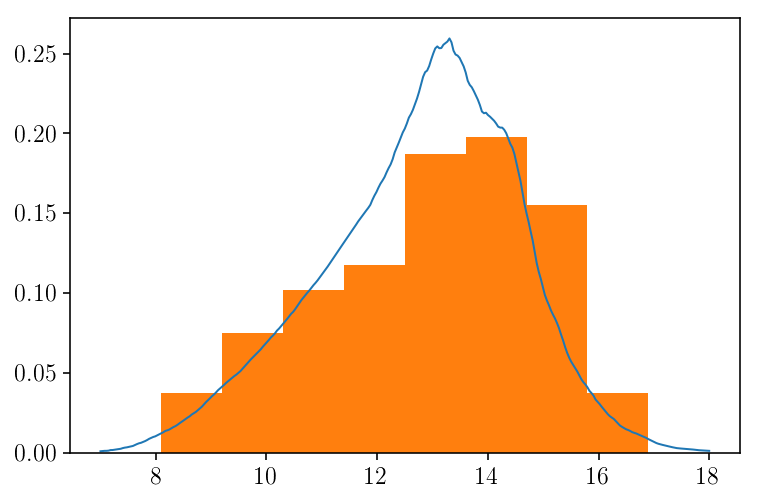

In [489]:
pdt = out.sum(axis=0)
pd = pdt/np.sum(pdt)/(distmods[1]-distmods[0])
plt.plot(distmods,pd)
plt.hist(data_distmod, normed=True, range=[distmods[0],distmods[-1]])